<img src=https://raw.githubusercontent.com/Deus99/skillfactory_rds/master/module_5/logo.jpg>

# BMW PRICE PREDICTION

Представьте, что вы работаете в компании, которая занимается продажей автомобилей с пробегом. Основная задача компании и ее менеджеров - максимально быстро находить выгодные предложения (проще говоря, купить ниже рынка, а продать дороже рынка).

Вам поставлена задача создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам.
Если наша модель работает хорошо, то мы сможем быстро выявлять выгодные предложения (когда желаемая цена продавца ниже предсказанной рыночной цены). Это значительно ускорит работу менеджеров и повысит прибыль компании.

В данном проекте изучаем только ценнобразование на автомобили **BMW**

## Загрузка модулей

In [1]:
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup
from threading import Thread
import queue
import time
import os
import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import plot_precision_recall_curve, mean_squared_error
from sklearn.preprocessing import power_transform
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, \
GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor

from mlxtend.regressor import StackingRegressor

from tqdm.notebook import tqdm

from catboost import CatBoostRegressor
import catboost

import xgboost as xgb
import optuna

import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
from hyperopt.fmin import fmin

from parser_mt import linkparser_mt, pageparser_mt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Используемые функции

In [2]:
def model_extract(row):
    """
    Производит поиск по шаблонам в столбце name, 
    выводит значение в столбец model
    """
    model = re.search(model_re, row['name'])
    if model is not None:
        row['model'] = model.group(0)
        
    model = re.search(model_x, row['name'])
    if model is not None:
        row['model'] = model.group(0)
    
    model = re.search(model_oth, row['name'])
    if model is not None:
        row['model'] = model.group(0)
    
    return row

def model_create(row):
    """
    Производит поиск по шаблонам в описании авто, 
    создает значение в столбце model_descr
    """
    model = re.search(model_re, row['descr'])
    if model is not None:
        row['name_descr'] = model.group(0)
    model = re.search(model_x, row['descr'])
    if model is not None:
        row['name_descr'] = model.group(0)    
    return row

def serie_creator(row):
    """
    Создает серию из цифры модели
    """
    if row['model'][0] == '5':
        row['serie'] = '5'
    elif row['model'][0] == '6':
        row['serie'] = '6'
    elif row['model'][0] == '7':
        row['serie'] = '7'
    elif row['model'][0] == '3':
        row['serie'] = '3'
    elif row['model'][0] == '2':
        row['serie'] = '2'
    elif row['model'] == 'Sere_2':
        row['serie'] = '2'
    elif row['model'][0] == '4':
        row['serie'] = '4'
    elif row['model'][0] == '1':
        row['serie'] = '1'
    elif row['model'][0] == '8':
        row['serie'] = '8'
    else:
        row['serie'] = row['model']
    return row

def auto_tax(row):
    """
    Расчет транспортного налога, от л.с. и возраста 
    """
    power = row['power']
    if power <= 100:
        tax_power = 12
    elif power <=125:
        tax_power = 25
    elif power <=150:
        tax_power = 35
    elif power <=175:
        tax_power = 45
    elif power <=200:
        tax_power = 50
    elif power <=225:
        tax_power = 65
    elif power <=250:
        tax_power = 75
    else:
        tax_power = 150
    row['tax'] = tax_power * power
    return row


class HPOpt(object):
    """
    Класс Hyperopt для XGB Regressor
    """

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test
    
    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials
    
    def xgb_reg(self, para):
        reg = xgb.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)
    
    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}
    
    

def price_round(price):
    """
    Округляет цены до целых значений с разным шагом
    """
    if price > 8500000:
        price = price = price / 250000
        price = np.round(price, 0)
        price = price * 250000
        
    elif price > 4000000:
        price = price / 100000
        price = np.round(price, 0)
        price = price * 100000
        
    elif (price <=4000000) and (price>2000000):
        price = price / 50000
        price = np.round(price, 0)
        price = price * 50000
        
    elif (price <=2000000) and (price>1000000):
        price = price / 25000
        price = np.round(price, 0)
        price = price * 25000
    else:
        price  = price / 10000
        price = np.round(price, 0)
        price = price * 10000
    return price

In [3]:
def horizontal_barplots(column, data, title_name):
    plt.rcParams['figure.figsize']=12,12
    ax = sns.barplot(x=0, y=column, hue='train', data=data)
    show_values_on_bars(ax, 'h', 10)
    plt.title(title_name)
    plt.show()

def horizontal_boxplots(col_x, col_y, data, title_name):
    plt.rcParams['figure.figsize']=16,8
    plt.ticklabel_format(style='plain', axis='x')
    ax = sns.boxplot( data=data, orient="h", x=col_x, y=col_y)
    plt.title(title_name)
    plt.show()

def vertical_boxplots(col_x, col_y, data, title_name, fsize=[16,8]):
    plt.rcParams['figure.figsize']=fsize[0], fsize[1]
    plt.ticklabel_format(style='plain', axis='x')
    ax = sns.boxplot( data=data, orient="v", y=col_x, x=col_y)
    plt.title(title_name)
    plt.show()

def horizontal_heatmap(col_x, col_y, data, title_name):
    maps = df.groupby([col_x, col_y])[col_x].count().unstack().T
    plt.rcParams['figure.figsize']=18,4
    sns.heatmap(maps);
    plt.title(title_name)
    plt.show()

def bars_counts(col, df, title_name):
    models = df[col].value_counts().reset_index()[0:25]
    models.columns = [col, 'quantity']
    plt.rcParams['figure.figsize']=12,10
    ax = sns.barplot(x='quantity', y=col, data=models)
    show_values_on_bars(ax, 'h', 10)
    plt.title(title_name)
    plt.show()

def histplot_train(col, df, title_name, bins=50):
    plt.rcParams['figure.figsize']=12,6
    plt.ticklabel_format(style='plain', axis='x')
    sns.histplot(x=col, hue='train', data=df, kde=True, bins=bins)
    plt.title(title_name)
    plt.show()

def showPlotsLog(col):
    ''' построим гистограммы, чтобы посмотреть распределение, но уже после логарифмирования '''
    df[col]=np.log(df[col]+1)
    df[col].hist(figsize=(10,5))
    
def showBoxplots(col):
    ''' построим boxplot '''
    fig,ax=plt.subplots(figsize=(10,4))
    sns.boxplot(y=col,x='price', data=df)
    plt.title(col)
    plt.show()
    
def outliers(column):
    ''' определяем квартили и границы выбросов для признаков '''
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    up = perc75 + 1.5*IQR
    print (column)
    k = 0
    for i in df[column]:
        if i <= low or i >= up:
            k+= 1
    if k > 0:
        print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
              , "IQR: {}, ".format(IQR),"Границы выбросов: [{}, {}],".format(low,up), 'Количество выбросов - ', k)
    else:
        print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
              , "IQR: {}, ".format(IQR), "Границы выбросов: [{}, {}],".format(low,up), 'Выбросов нет') 


def outliersUniform(col):
    '''находим выбросы и задаем значение внутри границ выбросов'''
    x=0
    perc25, perc75 = np.percentile(col, [25, 75])
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    up = perc75 + 1.5*IQR
    if type(col[0])==int:
        x=random.randint(low,up)
    else:
        x=random.uniform(low,up)
    for i in range(len(col)):
        if col[i] < low or col[i] > up:
            col[i] = x

def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() 
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()/2
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left", va ='center')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

### Шаблоны re

In [4]:
model_re = re.compile(r'(M|Z)?\d{2,3}[LidxAE](i,h)?')
model_x = re.compile(r'(X|M|Z|i)\d{1}')
model_oth = re.compile(r'(3|5)\d{2}e?')

## Используемые словари 

In [5]:
# словарь для переименований типов кузов
carbodies = {'внедорожник 5 дв.': 'suv_5d', 'кабриолет': 'cabriolet', 'компактвэн': 'comp_van', 
          'купе': 'coupe', 'купе-хардтоп': 'coupe_hardtop', 'лимузин': 'limousin', 'лифтбек': 'liftback', 
          'родстер': 'roadster', 'седан': 'sedan', 'седан 2 дв.': 'sedan_2d', 'универсал 5 дв.': 'universal_5w', 
          'хэтчбек 3 дв.': 'hatchbek_3d', 'хэтчбек 5 дв.': 'hatchbek_5d'}

colors = {'белый':'white', 'чёрный': 'black', 'синий': 'blue', 'серый': 'grey', 
          'серебристый': 'silver', 'бежевый': 'peach',
       'зелёный': 'green', 'красный': 'red', 'золотистый': 'gold', 'голубой': 'cyan', 
          'коричневый': 'brown','пурпурный': 'magenta', 'жёлтый': 'yellow', 
          'фиолетовый': 'violet', 'оранжевый': 'orange', 'розовый': 'rose'}

fuels = {'дизель': 'diesel', 'бензин': 'petrol', 'гибрид': 'hybrid', 'электро': 'electro'}

transms = {'механическая': 'mech', 'автоматическая': 'auto', 'роботизированная': 'robot'}

drives = {'задний': 'rear', 'полный':'full', 'передний': 'front'}

Всего в тестовом датафрейме 3837 автомобилей. Для обучения модели необходимо собрать исходные данных. Мы будем парсить сайт *auto.ru*.   

## Парсинг сайта auto.ru  

*Так исторически сложилось, что компания изначально не собирала данные. Есть только небольшой датасет с историей продаж, которого для обучения модели будет явно мало.*  
  

Парсинг сайта будет происходить в 2 этапа, вначале сбор ссылок с анкетами продажи авто, сохранение их в файл, устранение дубликатов ссылок(из-за проплаченных и др. объявлений), далее парсинг по страницам из этих ссылок и сбор данных. Т.к. данных очень (более 14000 ссылок для б/у авто) будем использовать многопоточный парсер сайта.  

*Еще одна особенность авто.ру , что выдает на странице без фильтров не более 3500-3700 ссылок. Для того, чтобы было больше, необходимо включать фтльтры на странице (год, модель, привод и т.д.).*

### Получение списка ссылок

In [6]:
"""
#linkparser_mt - парсит страницы автомобилей и сохраняет все в выходной файл c (номером года).csv 

""";

# brand = 'bmw'
#for year in range(2020, 1900, -2):  # шаг 2 года выдает по 2500 ссылок, что нас устраивает
#        bmw = linkparser_mt(year,brand)


In [7]:
bmw = pd.DataFrame()
path = r'data_bmw\\'

os.listdir(path)
for yearfile in os.listdir(path):
    df_year = pd.read_csv(path + yearfile)
    bmw = pd.concat([bmw, df_year])

bmw.sample(2)   

,Unnamed: 0,0
2682,2682,https://auto.ru/cars/used/sale/bmw/3er/1101369...
1132,1132,https://auto.ru/cars/used/sale/bmw/5er/1098815...


In [8]:
bmw = bmw[['0']]
bmw.columns = ['link']
bmw = bmw.drop_duplicates()
bmw.to_csv('bmw.csv', index=False)

bmw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13941 entries, 0 to 1208
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   link    13941 non-null  object
dtypes: object(1)
memory usage: 217.8+ KB


### Парсинг страниц с авто  
*Парсинг сайт был произведен ранее, поэтому воспользуемся загрузкой данных*

In [9]:
"""

# pageparser_mt - парсит по несколько страниц (зависит от количества ядер) и 
# сохраняет в выходной файл bmw_data.csv

bmw = pd.read_csv('bmw.csv')['link'].tolist()
all_results = pd.DataFrame()
bmw_data = pageparser_mt(bmw)
print('parsing complete')
bmw_data.to_csv('bmw_data.csv', index=False)
 """;

## Загрузка исходных данных  
Загружаем тестовый датафрейм **test1**, результаты парсинга **bmw_data** и объеденяем их в **df**

In [10]:
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('bmw_data.csv')

# Пометим train и test
df_train['train'] = 1
df_test['train'] = 0
df = pd.concat([df_train, df_test])

df.sample(3)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Привод,Руль,Состояние,Владельцы,ПТС,Владение,Таможня,price,id,train
980,хэтчбек 5 дв.,BMW,белый,бензин,2011.0,116i 1.6 AT (136 л.с.),5.0,2013.0,HATCHBACK_5_DOORS AUTOMATIC 1.6,автоматическая,...,задний,Левый,Не требует ремонта,3 или более,Оригинал,2 года и 2 месяца,Растаможен,NaN,980,0
9441,седан,BMW,белый,бензин,1998.0,BMW 7 серии III (E38) Рестайлинг 728i,4.0,1998.0,SEDAN AUTOMATIC 2.8,автоматическая,...,задний,Левый,Не требует ремонта,3 или более,Оригинал,2 года,Растаможен,375 000 ₽,https://auto.ru/cars/used/sale/bmw/7er/1085507...,1
1454,хэтчбек 5 дв.,BMW,чёрный,бензин,2007.0,BMW 1 серии I (E81/E82/E87/E88) Рестайлинг 116i,5.0,2009.0,HATCHBACK_5_DOORS AUTOMATIC 1.6,автоматическая,...,задний,Левый,Не требует ремонта,3 или более,Оригинал,NaN,Растаможен,420 000 ₽,https://auto.ru/cars/used/sale/bmw/1er/1101127...,1


## Data preprocessing - предварительная обработка данных

Проведем предварительную обработку данных, переименуем столбцы, значения, преобразуем типы переменнных, удалим пустые значения. 

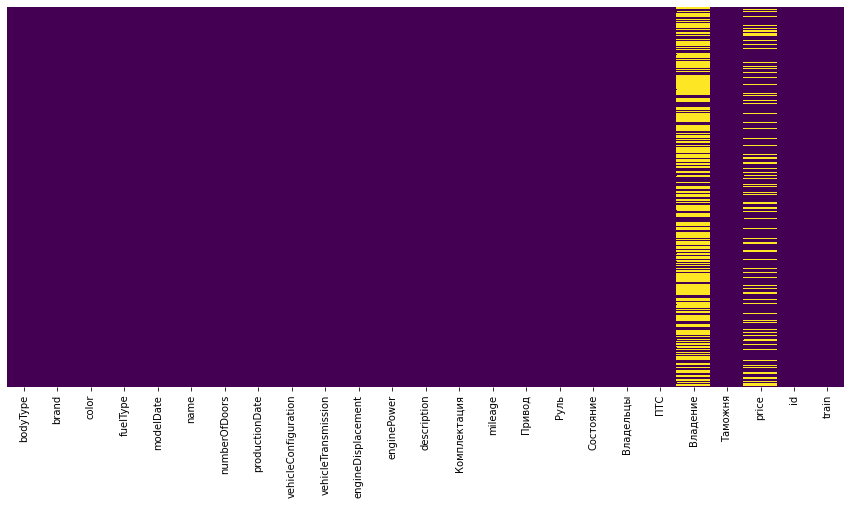

In [11]:
# посмотрим на все значения NAN
fig, ax = plt.subplots(figsize=(15,7))
sns_heatmap = sns.heatmap(df.sample(1000).isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [12]:
df.isna().sum()

bodyType                    0
brand                       0
color                       0
fuelType                    0
modelDate                   0
name                        0
numberOfDoors               0
productionDate              0
vehicleConfiguration        0
vehicleTransmission         0
engineDisplacement          0
enginePower                 0
description                 2
Комплектация                0
mileage                     2
Привод                      2
Руль                        2
Состояние                   2
Владельцы                   2
ПТС                         3
Владение                11632
Таможня                     3
price                    3837
id                          0
train                       0
dtype: int64

In [13]:
# изменим имена всех столбцов ( все буквы маленькие)
df.columns = df.columns.str.lower()
df.columns = ['bodytype', 'brand', 'color', 'fuel', 'model_year', 'name', 'doors', 'prod_year', 
              'veh_conf', 'transm', 'engine_displ', 'enginepower', 'descr', 'options', 'miles',
             'drive', 'wheel', 'rep_state', 'owners', 'pts', 'own', 'customs', 'price', 'id', 'train']

In [14]:
###############

# переименуем типы кузовов
df.loc[:,'bodytype'] = df.loc[:,'bodytype'].map(carbodies)

# Переименыем цвета
df.loc[:,'color'] = df.loc[:,'color'].map(colors)

# переименуем типы топлива
df.loc[:,'fuel'] = df.loc[:,'fuel'].map(fuels)

# Изменим типы переменных
df.model_year = df.model_year.astype(int)
df.doors = df.doors.astype(int)
df.prod_year = df.prod_year.astype(int)

# переименуем типы трансмиссии
df.loc[:,'transm'] = df.loc[:,'transm'].map(transms)

# У всех неэлектрокаров уберем литры
df.loc[df.fuel != 'electro', 'engine_displ'] = df.loc[df.fuel != 'electro', 'engine_displ'].apply(
    lambda x: x.split()[0])

# У электрокаров объем - ноль
df.loc[df.fuel == 'electro', 'engine_displ'] = 0

# Изменяем тип переменной str-->float - 
df.loc[:, 'engine_displ'] = df.loc[:, 'engine_displ'].astype(float)

# Мощность двигателя
# Разобьем на 2 столбца - мощность и марка(поколение) двигателя
df[['power', 'engine']] = df['enginepower'].str.split(' ', n=1, expand=True)
df.loc[:,'power'] = df.loc[:,'power'].astype(int)

# Удаляем 2 строки с пропусками большинства параметров
df = df[~df['drive'].isna()]


# Уберем лишние символы из километражаи преобразуем тип переменной
df.loc[df.train==1, 'miles'] = df.loc[
    df.train==1, 'miles'].str.replace('км', '').str.replace(u'\xa0', u'')
df.miles = df.miles.astype(int)



# Переименуем тип привода
df.loc[:, 'drive'] = df.loc[:, 'drive'].map(drives)

# Переименуем тип положения руля
df['wheel'] = df['wheel'].map({'Левый': 'left', 'Правый': 'right'})

# Владельцы
df['owners'] = df['owners'].apply(lambda x: str(x).split()[0])

# ПТС
df['pts'] = df['pts'].map({'Оригинал': 'original', 'Дубликат': 'duplicate'})

# удалим буквы и лишние символы в цене, также удалим значения 0 в цене(авто проданы)
df.loc[df.train==1, 'price'] = df.loc[df.train==1, 'price'].str.replace('₽', '').str.replace(u'\xa0', u'').astype('float')
df = df[df.price!=0]

# Создание временного столбца 'model' из 'name'
# Данные собираем в 'model' 


# Все авто в данном исследовании BMW - столбец brand не нужен
# Столбец vehicle configuration - столбец из других bodytype, engine, transmisiion
# Столбец - own последнее владение, слишком много данных пропущено


In [15]:
# Собираем модели из name
df = df.apply(model_extract, axis=1) 

# Собираем модели из описания
df = df.apply(model_create, axis=1)  

In [16]:
# Создаем модель из названия 
df.loc[df.name.str.contains('4.4 AMT'), 'model'] = 'M5'
df.loc[df.name.str.contains('5.0 AMT'), 'model'] = 'M5'
df.loc[df.name.str.contains('CS 3.0 AMT'), 'model'] = 'M4'
df.loc[df.name.str.contains('3.0 AMT \(431 л.с.\)'), 'model'] = 'M4'
df.loc[df.name.str.contains('4.0 AMT \(420 л.с.\)'), 'model'] = 'M3'
df.loc[df.name.str.contains('Competition Package 3.0 AMT'), 'model'] = 'M3'
df.loc[df.name.str.contains('Competition 4.4 AT'), 'model'] = 'M5'
df.loc[df.name.str.contains('4.4 AT \(600 л.с.\) 4WD'), 'model'] = 'M5'
df.loc[df.name.str.contains('3.0 AMT \(410 л.с.\)'), 'model'] = 'M2'
df.loc[df.name.str.contains('Electro AT \(126 кВт\)'), 'model'] = 'i3'
df.loc[df.name.str.contains('BMW 2 серии F22 Рестайлинг'), 'model'] = '2'
df.loc[df.name.str.contains('1.5 AT \(136 л.с.\)'), 'model'] = '2'
df.loc[df.name.str.contains('ActiveHybrid 4.4hyb AT'), 'model'] = 'X6'
df.loc[df.name.str.contains('3.0sd 3.0d AT \(286 л.с.\) 4WD'), 'model'] = 'X3'
df.loc[df.name.str.contains('1.5hyb AT \(231 л.с.\) 4WD'), 'model'] = 'i8'
df.loc[df.name.str.contains('Active Hybrid 7L'), 'model'] = '7L'
df.loc[df.name.str.contains('Active Hybrid 7'), 'model'] = '7'
df.loc[df.name.str.contains('BMW E3'), 'model'] = 'E3'
df.loc[df.name.str.contains('BMW 3/15 DA-4'), 'model'] = '3/15 Rare'
df.loc[df.name.str.contains('BMW 02'), 'model'] = 'E10'
df.loc[df.name.str.contains('3.0 AT \(265 л.с.\)'), 'model'] = 'Z4'
df.loc[df.name.str.contains('2.0 MT \(150 л.с.\)'), 'model'] = '520'
df.loc[df.name.str.contains('M7'), 'model'] = '7'
df.loc[df.name.str.contains('Х6'), 'model'] = 'X6'
df.loc[df.name.str.contains('Х4'), 'model'] = 'X4'

df.model = df.model.fillna(df.name_descr)
df.loc[(df.model.isna())&(df.bodytype=='suv_5d'), 'model'] = 'X5'
df.loc[df.model.isna(), 'model'] = '5'
# убираем тип двигателя из названия
df.model = df.model.apply(lambda x: str(x).replace('d','')) 


df = df.drop(columns = ['brand', 'veh_conf', 'engine', 'enginepower', 'rep_state', 
                        'own', 'customs', 'name_descr' , 'name'])

In [17]:
df.head(3)

,bodytype,color,descr,doors,drive,engine_displ,fuel,id,miles,model,model_year,options,owners,power,price,prod_year,pts,train,transm,wheel
0,sedan,white,"Отличный авто. Небольшой расход, отличная дина...",4,rear,2.0,diesel,https://auto.ru/cars/used/sale/bmw/5er/1095912...,220000,520,2007,"['Электростеклоподъёмники задние', 'Электросте...",3,177,610000.0,2008,original,1,mech,left
2,suv_5d,black,Автомобиль радует! Как бы странно не звучало н...,5,full,4.8,petrol,https://auto.ru/cars/used/sale/bmw/x5/11010944...,203000,X5,2006,"['Круиз-контроль', 'Электрорегулировка руля', ...",3,355,780000.0,2007,duplicate,1,auto,left
3,sedan,black,Богатая комплектация: 2-х зонный климат-контро...,4,rear,2.0,petrol,https://auto.ru/cars/used/sale/bmw/3er/1098844...,118000,320,2008,[],3,156,660000.0,2008,original,1,auto,left


## EDA - Разведывательный анализ данных

<img src="https://raw.githubusercontent.com/Deus99/skillfactory_rds/master/module_5/eda_v2.jpg">

In [18]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
bodytype,17777,13,sedan,8301,NaN,NaN,NaN,NaN,NaN,NaN,NaN
color,17777,16,black,6867,NaN,NaN,NaN,NaN,NaN,NaN,NaN
descr,17777,17017,Купить автомобиль с пробегом в РОЛЬФ — это быс...,103,NaN,NaN,NaN,NaN,NaN,NaN,NaN
doors,17777,NaN,NaN,NaN,4.34055,0.767618,2,4,4,5,5
drive,17777,3,full,9514,NaN,NaN,NaN,NaN,NaN,NaN,NaN
engine_displ,17777,NaN,NaN,NaN,2.66798,0.841411,0,2,2.5,3,6.6
fuel,17777,4,petrol,12741,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id,17777,17777,1944,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
miles,17777,NaN,NaN,NaN,162588,107530,1,86000,146700,220504,1e+06
model,17777,131,X5,2620,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Всего в датафрейме 20 столбцов. Столбцы **id** и **train** носят технический характе и не будут рассматриваться. Столбцы **descr, options** - комментарии продавца и список опций, будут переработаны в следующем разделе.  

-----------------
##### Категориальные признаки
**bodytype** - тип кузова, начиная от кабриолета, купе и заканчивая внедорожников.  
**color** - цвет кузова  
**doors** - количество дверей. Считаем категориальным признаком, количество дверей влияет на компоновку и комфорт, а не на технические характеристики  
**drive** - привод, передний, задний или полный  
**engine_displ** - объем двигателя в литрах  
**fuel** - тип топлива, например бензин  
**model** - Наименование модели, например *X5*   
**model_year** - год запуска модели в производство. Все модели *BMW* отличаются разным поколением, рестйайлингом и пр.  
**owners** - количество владельцев по ПТС: 1,2, 3 и более  
**transm** - тип трансмисии, например - автоматическая (*auto*)  


##### Числовые признаки
**miles** - пробег в километрах(!!)  
**power** - мощность авто в л.с.  
**price** - цена в рублях   
**prod_year** - год производства  


##### Бинарные признаки
**pts** - наличие оригинального ПТС или дубликата  
**wheel** - положение рулевого колеса: слева или справа  

## Анализ категориальных признаков

### bodytype - тип кузова

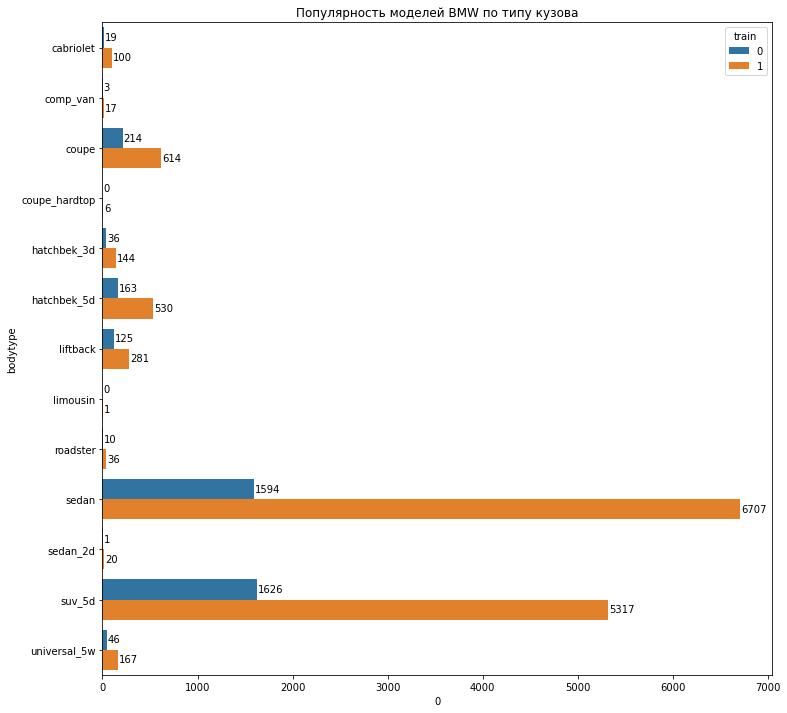

In [19]:
#группируем данные, преобразоваваем, чтобы не было потерь в NAN
bmw_group = df.groupby(['bodytype', 'train'], dropna=False)['bodytype'].count().unstack().fillna(0).unstack().reset_index()
horizontal_barplots('bodytype', bmw_group, 'Популярность моделей BMW по типу кузова')

Самые популярные типы кузовов - **sedan** и **suv_5d** (привет, X5). Все остальные испольнения менне популярны. Также в тестовых данные отсутвуют редкие марки типа лимузина и купе с жесткой крышей (*coupe_hardtop*). Также стоит отметить, что наличие дверей указано в компоновке кузова (возможно признак наличия дверей станет не нужен).   
На данные момент удаляем 2 редких кузова **limousin** и **coupe_hardtop**

In [20]:
# удаляем типы кузовов
df = df.loc[~df.bodytype.isin(['limousin','coupe_hardtop'])]

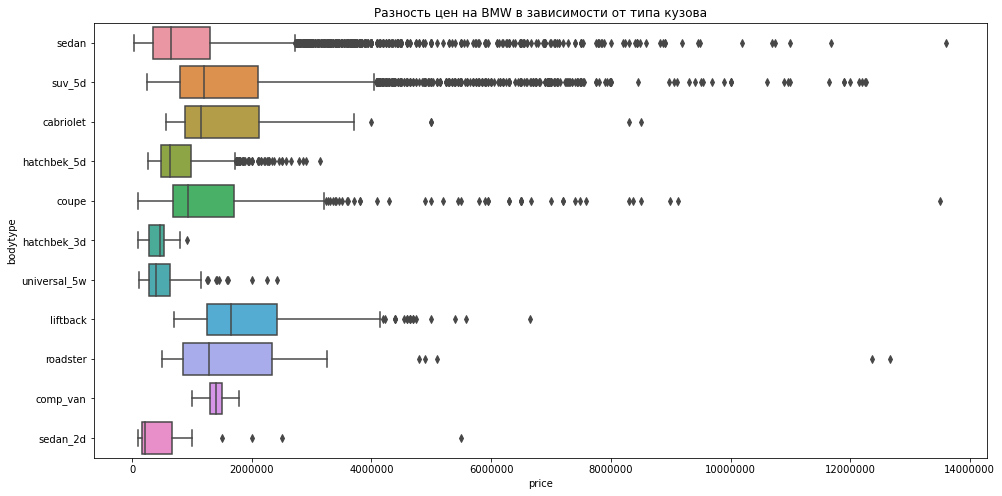

In [21]:
horizontal_boxplots('price', 'bodytype', df, 'Разность цен на BMW в зависимости от типа кузова')

Между ценами на тип кузова очень большие различия, как по цене, так и по разбросу. Можно было бы считать если бы цена на автомобиль на зависела от других факторов, как пробег и год выпуска.

### color - цвет кузова

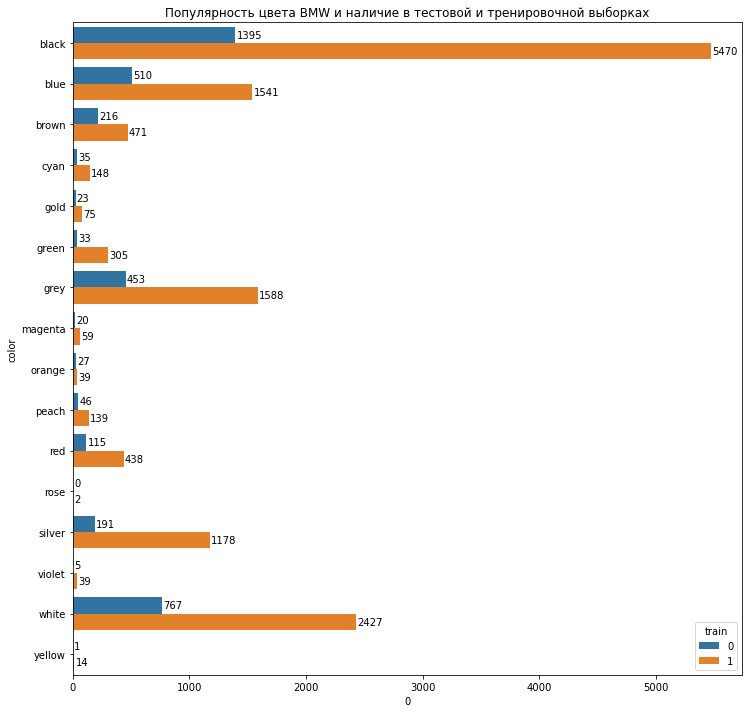

In [22]:
#группируем данные, преобразоваваем, чтобы не было потерь в NAN
bmw_color = df.groupby(['color', 'train'], dropna=False)['color'].count().unstack().fillna(0).unstack().reset_index()
horizontal_barplots('color', bmw_color, 'Популярность цвета BMW и наличие в тестовой и тренировочной выборках')

Предсказуемо в России предпочитают черные БМВ, видимо как привет из 90-х. Далее идут белые, серые и синие(!!). На дорогах можно встретить BMW более редких цветок, таких как фиолетовый, персиковый, золотой и одна с аэрографией "Рика и Морти" , но она похоже не продается. Зато продается BMW в редком розовом цвете:  встречается только 2 раза и только в обучающей выборке, поэтому его удалим.

In [23]:
# удаляем розовый цвет из данных
df = df.loc[~(df.color=='rose')]

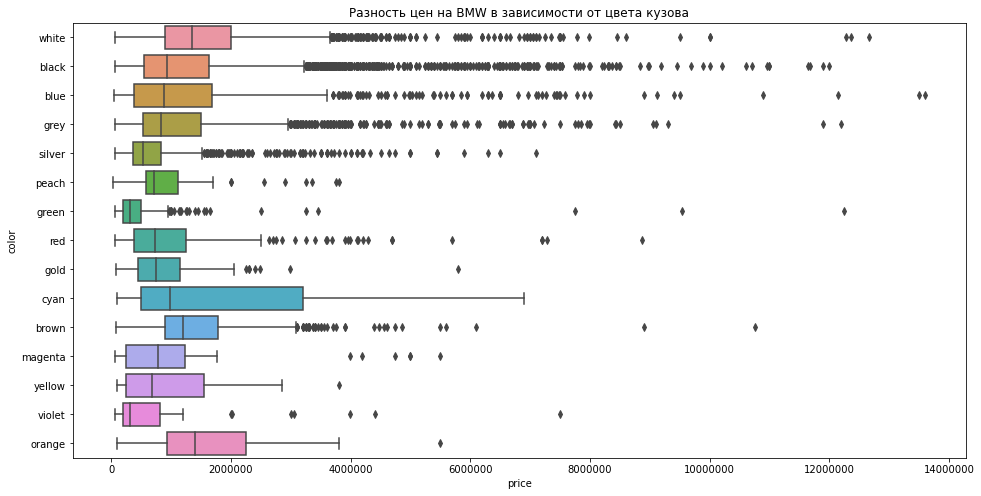

In [24]:
horizontal_boxplots('price', 'color', df, 'Разность цен на BMW в зависимости от цвета кузова')

Похожая ситуация, что и с типом кузова. Чем более распростанен цвет, тем там больше "выбросов" на боксплотах, но это опять связано с популярностью марки, и годом выпуска. Б/у авто 2000 года может стоит в несколько раз меньше, чем почти новый X5.

### doors - количество дверей

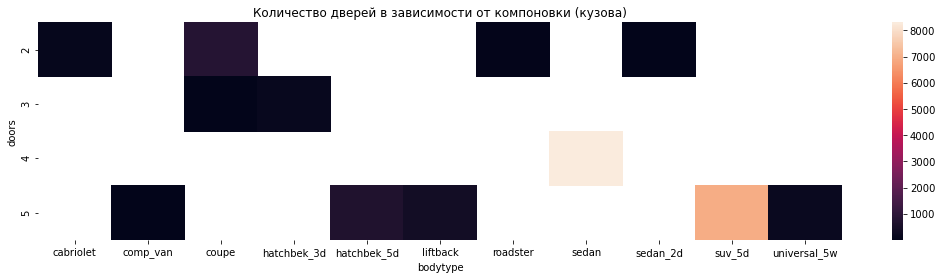

In [25]:
horizontal_heatmap('bodytype', 'doors', df, 'Количество дверей в зависимости от компоновки (кузова)')

Из таблицы видно, что кузов, полностью соответвует количеству дверей (3х дверное купе - ошибка). 5-ти дверных машин больше всего(внедорожники). Т.к. покупатели ориентируются на тип кузова, тот этот столбец можно удалить

In [26]:
# удаляем столбец - двери
df.drop(columns=['doors'], inplace=True)

### drive - тип привода  
Посмотрим на комбинации типа привода и модели автомобиля. Всего представлено 3 типа привода: *front* - передний, *full* - полный, *rear* - задний

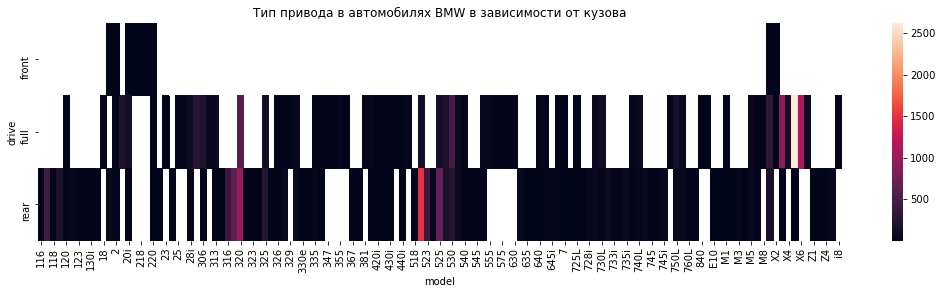

In [27]:
horizontal_heatmap('model', 'drive', df, 'Тип привода в автомобилях BMW в зависимости от кузова')

Из тепловой карты видно, что BMW в основном задне и полноприводные, а некоторые модели, например 20i или X1, можно найти с любым приводом.

In [28]:
df.drive.value_counts()

full     9514
rear     8177
front      77
Name: drive, dtype: int64

### engine_displ - объем двигателя

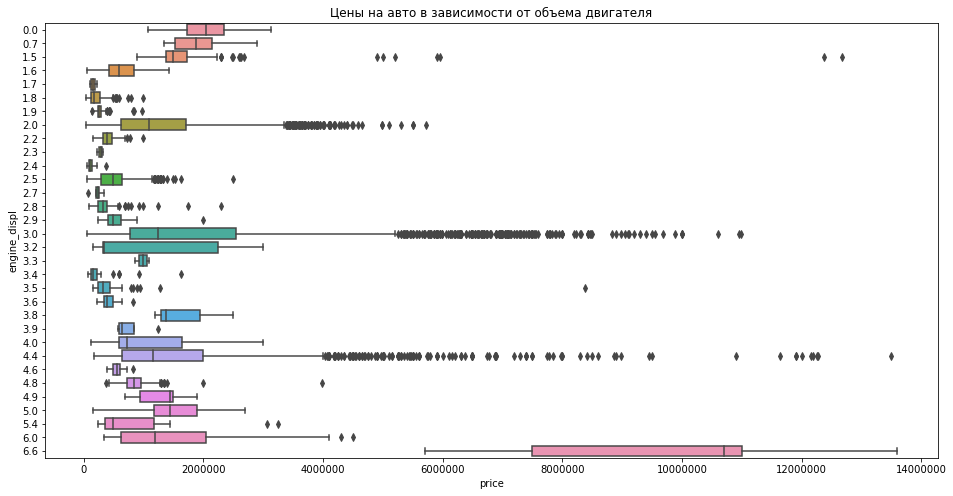

In [29]:
horizontal_boxplots('price', 'engine_displ', df, 'Цены на авто в зависимости от объема двигателя')

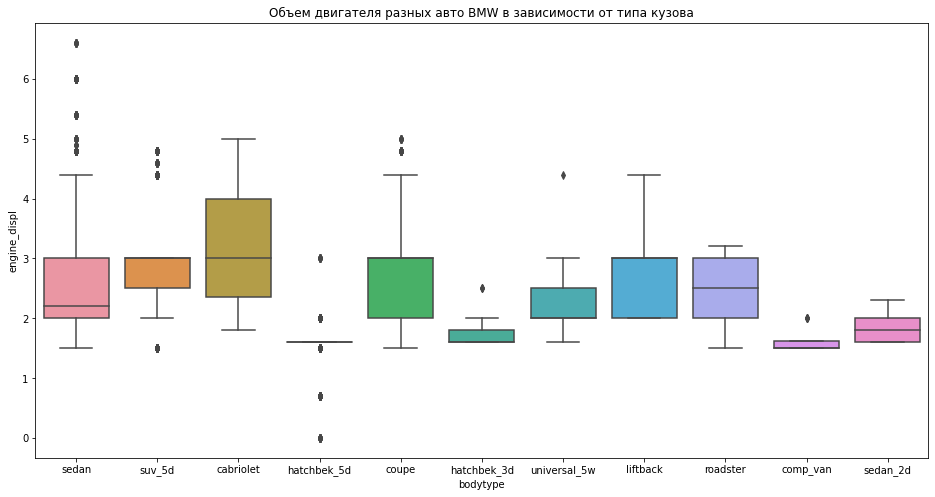

In [30]:
vertical_boxplots('engine_displ', 'bodytype', df, 'Объем двигателя разных авто BMW в зависимости от типа кузова')

Что можно сказать про объемы двигателей? Почти все от 2х литров и больше.   Также есть **M** класс, с увеличенным объемом двигателя и мощностью (и ценой).     Электромобили и гибриды выпускаются в исполнение 5ти дверного хэтчбека,  а **Z** серия в исполнение кабриолета со средним объемом 3,5л.  
Цена на авто зависит от объема двигателя, но здесь нет зависимости, цена больше привязана к модели авто, а также к году выпуска(некоторые модели двигателя есть только на старых авто). 
*Примечание*. Гибриды и электоромобили  выпускаются в кузове 5ти дверный хетчбек, поэтому объем двигателя меньше, до нуля. 

In [31]:
df.engine_displ.value_counts(bins=10).sort_index()

(-0.0076, 0.66]      21
(0.66, 1.32]         33
(1.32, 1.98]       1416
(1.98, 2.64]       7909
(2.64, 3.3]        6210
(3.3, 3.96]         139
(3.96, 4.62]       1565
(4.62, 5.28]        402
(5.28, 5.94]         24
(5.94, 6.6]          49
Name: engine_displ, dtype: int64

### fuel - тип топлива

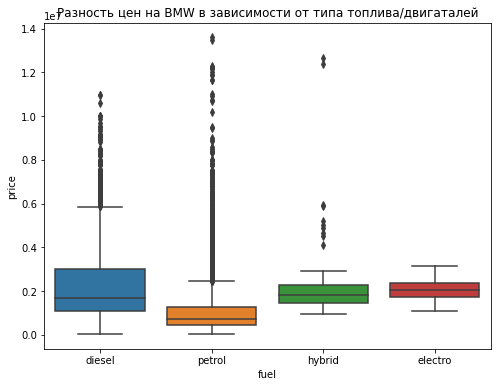

In [32]:
vertical_boxplots('price', 'fuel', df, 'Разность цен на BMW в зависимости от типа топлива/двигаталей', fsize=[8,6])

Авто с бензиновыми двигателями наиболее дешевые, а электродвигатели и гибриды более дорогие. Тем не менее самые дорогие авто тоже с бензиновым двигателем (около 14 млн!). 

In [33]:
df.fuel.value_counts()

petrol     12732
diesel      4951
hybrid        64
electro       21
Name: fuel, dtype: int64

### model - модель в линейке BMW

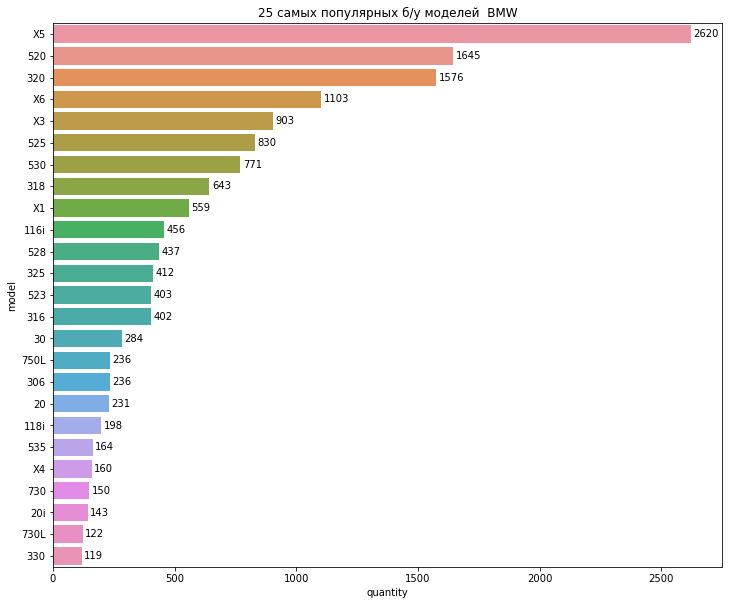

In [34]:
bars_counts('model', df, '25 самых популярных б/у моделей  BMW')

Посмотрим на 25 самых популярных моделей. В основном это модели X5, а также 3й и 5й серии. При том, что всего моделей 117.

In [35]:
df.groupby(['train', 'model'])['model'].size().unstack()

model,116,116i,118,118i,120,120i,123,125i,130i,135i,...,X3,X4,X5,X6,X7,Z1,Z3,Z4,i3,i8
train,,,,,,,,,,,,,,,,,,,,,
0,NaN,102.0,1.0,40.0,13.0,10.0,NaN,4.0,1.0,NaN,...,3.0,1.0,114.0,1.0,NaN,NaN,NaN,3.0,1.0,5.0
1,1.0,354.0,3.0,158.0,16.0,40.0,1.0,11.0,6.0,9.0,...,900.0,159.0,2506.0,1102.0,66.0,1.0,11.0,30.0,53.0,7.0


Также стоит обратить внимание на то, что часть моделей представлены только в одном из датасетов. Например *Z1* и *Z3* есть только в *train*, а 20 модель представлена только в *test*. Возможно стоит создать кроме наименования модели, еще самую серию, которой приндлежит авто (например Z-серия илт 7-серия) 

### model_year - год запуска модели в производство (поколение)

Все модели *BMW*  каждые несколько лет подвергаются изменению внешнего дизайна (рейсталингу) или запуска другой линейки двигателей. 

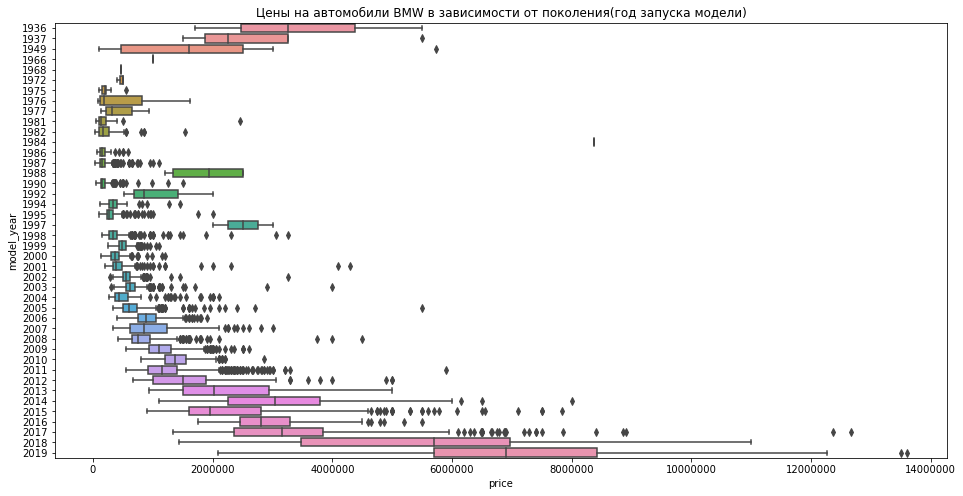

In [36]:
horizontal_boxplots('price', 'model_year', df, 'Цены на автомобили BMW в зависимости от поколения(год запуска модели)')

Можно сразу сделать вывод: в датасете есть автомобили, которые можно считать раритетными, и они скорее всего по 1-2 шт. Но есть ли они в тестовых данных. Не каждый день пользователи продают раритеты через интернет-сайт. Интересно, что за модели 1997 г. более чем за 2 млн рублей

In [37]:
df[df.train==0].model_year.min()

1975

Все что ранее 1975 года выпуска нет смысла оставлять в датасете, это очень редкие модели и их мало. Но с этим признаком еще полезно поработать позже, из него можно извлечь необходимую нам серию/поколение авто.

In [38]:
# убираем лишние авто
df = df[df.model_year>=1975]

### owners - количество собственников

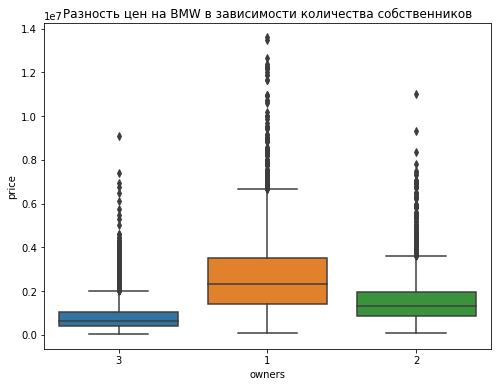

In [39]:
vertical_boxplots('price', 'owners', df, 'Разность цен на BMW в зависимости количества собственников', fsize=[8,6])

Каждый знает, что лучше покупать авто, только у первого хозяина, без лизингов и огромного числа владельцев. Боксплоты также это подтверждают. К сожалению, чаще всего у автомобиля более 3х владельцев. На этот показатель влияет возраст авто.

In [40]:
df.owners.value_counts()

3    9701
2    4174
1    3874
Name: owners, dtype: int64

### transmission - тип трансмиссии

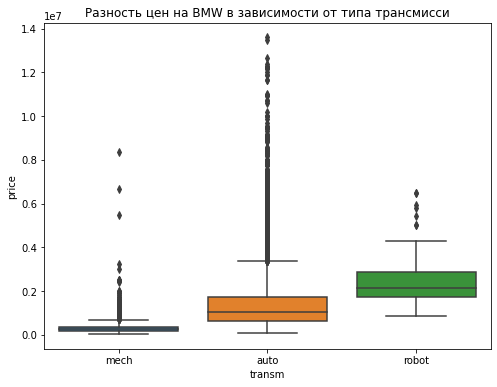

In [41]:
vertical_boxplots('price', 'transm', df, 'Разность цен на BMW в зависимости от типа трансмисси', fsize=[8,6])

Автоматическая трансмиссия занимает примерно 90% от общего числа автомобилей в исследовании. Ручная коробка на автомобилях более ранних серий. Робот встречается на автомобилях спортивных серий, что отражается на цене.

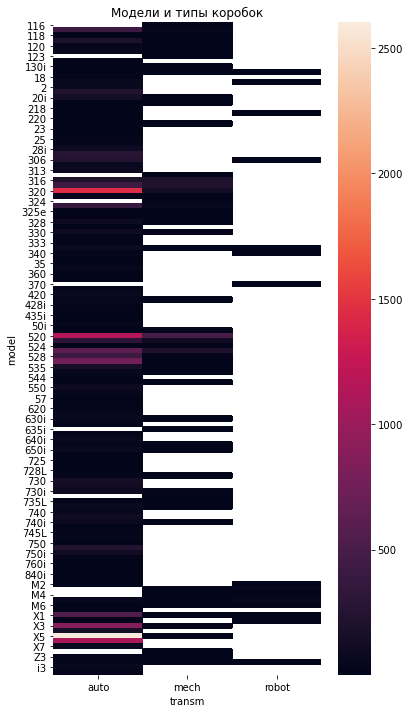

In [42]:
transm_var = df.groupby(['transm', 'model'])['model'].count().unstack().T
plt.rcParams['figure.figsize']=6,12
sns.heatmap(transm_var);
plt.title('Модели и типы коробок')
plt.show()

Многие серии испльзую только автоматическую коробку, но можно найти некоторые серии, где ставятся разные коробки (335, Z4)

In [43]:
df.transm.value_counts()

auto     15781
mech      1789
robot      179
Name: transm, dtype: int64

## Анализ бинарных признаков

### pts - ПТС( оригинал или дубликат)

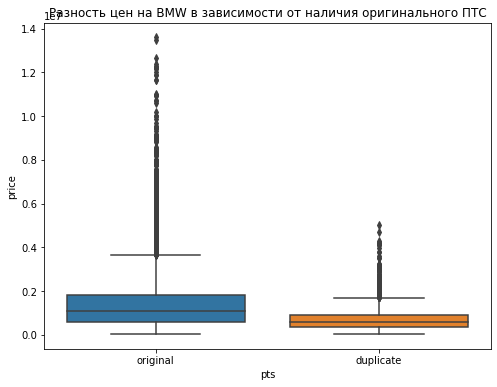

In [44]:
vertical_boxplots('price', 'pts', df, 'Разность цен на BMW в зависимости от наличия оригинального ПТС', fsize=[8,6])

В целом авто с оригинальными ПТС стоят дороже, очень дорогие авто (>6 млн) с дубликатом не продаются. 

In [45]:
# есть пара строк с пропусками
df = df[~df.pts.isna()]

In [46]:
df.pts.value_counts()

original     14584
duplicate     3164
Name: pts, dtype: int64

### wheel - левый или правый руль

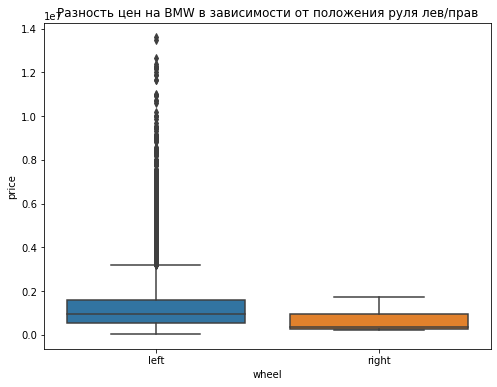

In [47]:
vertical_boxplots('price', 'wheel', df, 'Разность цен на BMW в зависимости от положения руля лев/прав', fsize=[8,6])

Здесь все предсказуемо, всегде есть вариант купить такое же авто, но с левым рулем. Единственное, почему люди покупают авто с правым рулем, значительно более низкая цена, что видно из боксплотов.  

In [48]:
df.wheel.value_counts()

left     17731
right       17
Name: wheel, dtype: int64

В данных всего всего 17 праворуких BMW, и их нет в тестовых данных, если бы мы предсказывали цены на Tayota, это был бы важным признаком, но в данном случае его можно удалить.  
*Примечание. на сервисах оценки авто (auto.ru) для BMW нет правого руля*

In [49]:
df.drop(columns=['wheel'], inplace=True)

## Анализ числовых признаков

### miles - пробег в километрах

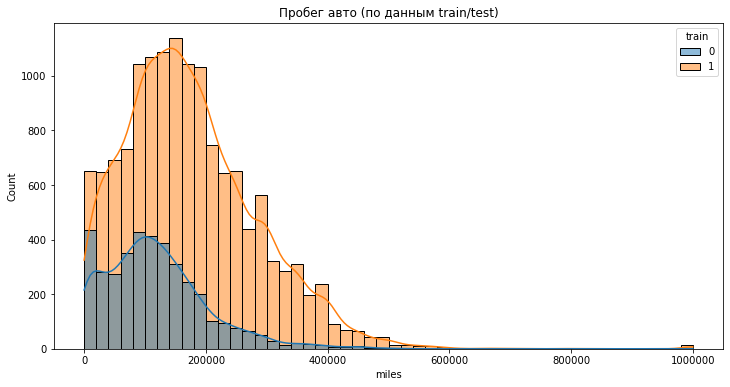

In [50]:
histplot_train('miles', df, 'Пробег авто (по данным train/test)')

На графике виден автомобиль с 1 млн км !!!!. Проверим данные на выбросы. 

In [51]:
print(outliers('miles'))

miles
25-й перцентиль: 86077.5, 75-й перцентиль: 220910.0, IQR: 134832.5,  Границы выбросов: [-116171.25, 423158.75], Количество выбросов -  314
None


Посмотрим на авто со слишком малым пробегом, часть это - восставновленные авто, одно авто с ошибкой (парсинг или сайт) 435 км. Для того чтобы актуально оценивать восстановленные авто. Мы им добавим медианный пробег для данного годы, а сами авто вынесем в отдельную категорию - *rebuild_car*

In [52]:
# Исправляем ошибки
df.loc[(df.miles==435), 'miles'] = 435000
df.loc[(df.miles==999)&(df.prod_year<2009), 'miles'] = 999000
df.loc[(df.miles==1000)&(df.prod_year<2009), 'miles'] = 1000000 

In [53]:
# Группируем пробег каждые 50 тыс км
miles_price = df[df.train==1]
miles_price = miles_price.groupby(miles_price.miles//50000)['price'].mean().reset_index()
miles_price['miles'] = miles_price['miles'] * 50

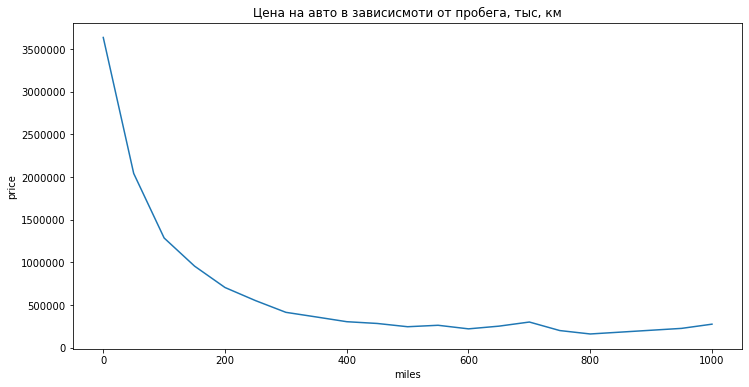

In [54]:
plt.ticklabel_format(style='plain', axis='y')
plt.title('Цена на авто в зависисмоти от пробега, тыс, км')
sns.lineplot(data=miles_price, x='miles', y='price');

В тестовой выборке также есть значения около 1 млн км. Стоит сохранить данные, можно сохранить данные как есть. Можно преобразовать данные, например ограничить максимальное значение одометра 500,000. Многие авто имеет, гораздо меньший пробег, например новые модели. Также необходимо нормализовать признак( провести логарифмирование или преобразование Бокса-Кокса). Когда продают авто с таким пробегом, это уже не так важно, более играет роль год выпуска и техническое состояние.  

И еще не маловажный момент, известно, что пробег скручивают))

### power - мощность двигателя

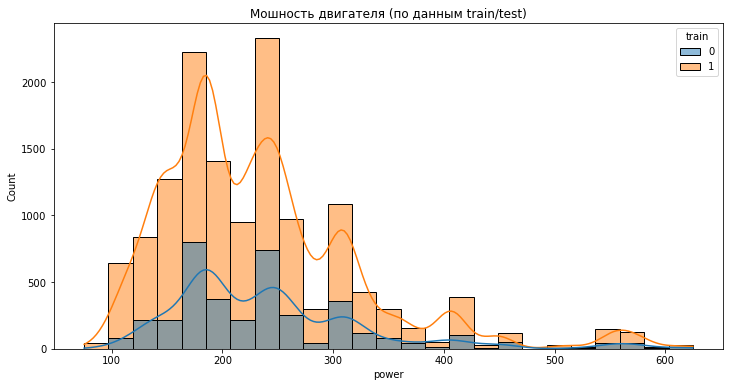

In [55]:
histplot_train('power', df, 'Мошность двигателя (по данным train/test)', bins=25)

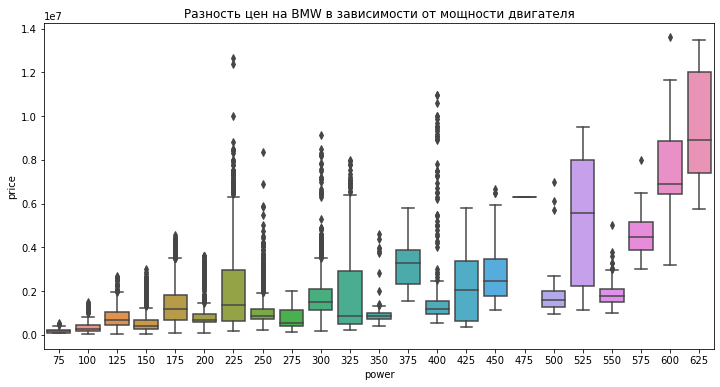

In [56]:
powers = df.query('train==1')[['power', 'price']]
powers['power'] = powers['power'] // 25
powers['power'] = powers['power'] * 25 
vertical_boxplots('price', 'power', powers, 'Разность цен на BMW в зависимости от мощности двигателя', fsize=[12,6])

Интересный момент, что после мощности 250 цена падает, по сравнению с 225. Есть такая особенность, в продажах авто, как налог на л.с. и свыше 250 л.с. и и так же привязан к средней стоимости и возрасту авто. На стоимость этот фактор влияет, т.е. в объявлениях иногда указана сумма налога. 

### prod_year - год производства

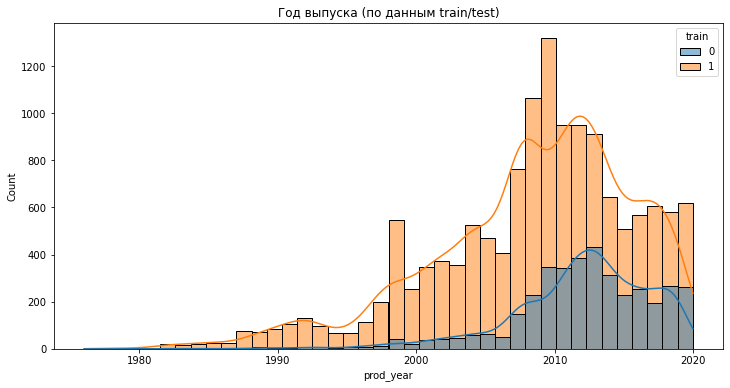

In [57]:
histplot_train('prod_year', df, 'Год выпуска (по данным train/test)', bins=40)

In [58]:
df[df.train==0].prod_year.min()

1981

Из данных видно, что много "лишних" авто старше 1980 года в обучающей выборке. Мы их удалим.  
Также стоит учесть, что при покупке больше интересует возраст, поэтому преобразуем этот признак а **car_age**

In [59]:
df = df[df.prod_year>1980]
df.rename(columns = {'prod_year': 'car_age'}, inplace=True)
df.loc[:, 'car_age'] = 2020 - df.loc[:, 'car_age']

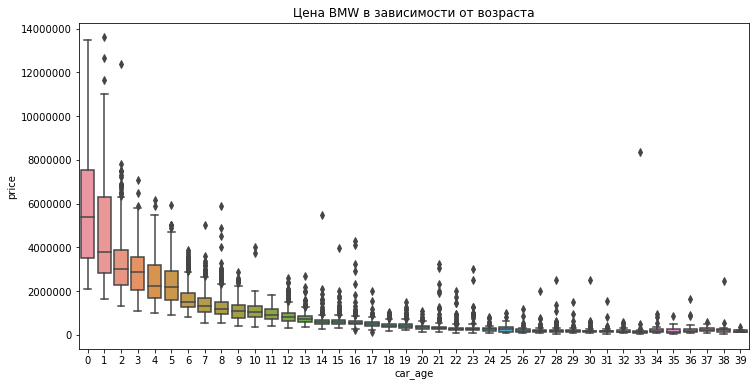

In [60]:
plt.ticklabel_format(style='plain', axis='y')
vertical_boxplots('price', 'car_age', df, 'Цена BMW в зависимости от возраста', fsize=[12,6])

После 14 лет средняя цена на авто почти не меняется. "Выбросы" принадлежат спорткарам, броневикам и пр. особенным моделям.

### price - цена   
Рассмотрим распределение цен на BMW, на гистограмме отмечены квантили 25%, 75% и медиана (930 т.р.) 

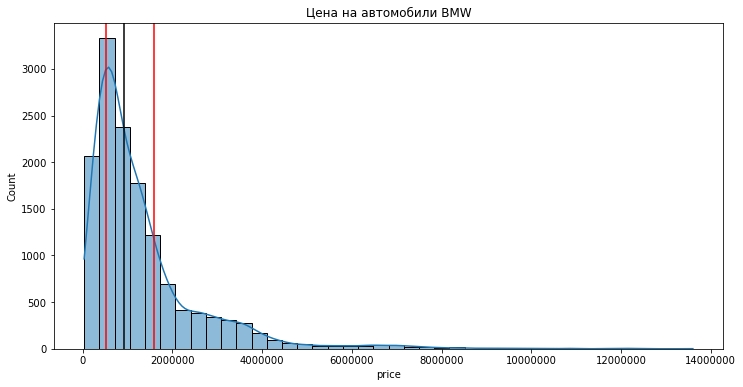

In [61]:
plt.rcParams['figure.figsize']=12,6
plt.ticklabel_format(style='plain', axis='x')
sns.histplot(x='price', data=df, kde=True, bins=40)
plt.title('Цена на автомобили BMW')
plt.axvline(1600000, 0,3000, color='red')
plt.axvline(530000, 0,3000, color = 'red')
plt.axvline(930000, 0,3000, color = 'black')
plt.show()

In [62]:
pd.options.display.float_format = '{:.2f}'.format
df['price'].describe()

count      13900.00
mean     1336719.20
std      1327916.47
min        36000.00
25%       530000.00
50%       930000.00
75%      1600000.00
max     13600000.00
Name: price, dtype: float64

Из графика видно, что при медианной цене 930 т.р. максимальная около 14 млн. Возможно стоит завести отдельный признак для цены, чтобы выделить очень дорогие или очень дешевые авто. Позже логарифмируем этот признак.

### Изменения признаков после EDA
Оказались ненужными: количество дверей, положение руля (**doors**, **wheel**). Признак год выпуск - преобразован в признак возраст автомобиля (**prod_year** --> **car_age**). Два столбца: описание (**descr**) и год запуска модели (**model_year**) будут далее в *Feature Engineering*

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17737 entries, 0 to 3836
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bodytype      17737 non-null  object 
 1   color         17737 non-null  object 
 2   descr         17737 non-null  object 
 3   drive         17737 non-null  object 
 4   engine_displ  17737 non-null  float64
 5   fuel          17737 non-null  object 
 6   id            17737 non-null  object 
 7   miles         17737 non-null  int64  
 8   model         17737 non-null  object 
 9   model_year    17737 non-null  int64  
 10  options       17737 non-null  object 
 11  owners        17737 non-null  object 
 12  power         17737 non-null  int64  
 13  price         13900 non-null  float64
 14  car_age       17737 non-null  int64  
 15  pts           17737 non-null  object 
 16  train         17737 non-null  int64  
 17  transm        17737 non-null  object 
dtypes: float64(2), int64(5), ob

## FEATURE ENGENEERING

### description - описание автомобиля от продавца

При изучении отзывов можно выделить несколько моментов: продавцы могут быть разные, салон(trade-in) или сам владелец авто. Как правило у салонов цена чуть выше, но это мы еще проверим. Когда продают сами владельцы, то иногда указывают торг уместен или нет. Иногда также перед торгом цену чутка завышают, и это тоже проверим

In [64]:
# Создание столбца дилеры
df.loc[df.descr.str.lower().str.contains('рольф'), 'dealer'] = 'rolf'
df.loc[df.descr.str.lower().str.contains('организация продаж автомобилей с пробегом'), 'dealer'] = 'rolf'
df.loc[df.descr.str.lower().str.contains('бесплатная техническая и юридическая'), 'dealer'] = 'rolf'
df.loc[df.descr.str.lower().str.contains('ключавто'), 'dealer'] = 'kluchauto'
df.loc[df.descr.str.lower().str.contains('автодом'), 'dealer'] = 'autodom'
df.loc[df.descr.str.lower().str.contains('autodom'), 'dealer'] = 'autodom'
df.loc[df.descr.str.contains('ABTODOM'), 'dealer'] = 'autodom'
df.loc[df.descr.str.lower().str.contains('по более 40 параметрам'), 'dealer'] = 'auto_expert'
df.loc[df.descr.str.lower().str.contains('по более 48 параметрам'), 'dealer'] = 'auto_expert'
df.loc[df.descr.str.lower().str.contains('услугой трейд-ин'), 'dealer'] = 'rolf'
df.loc[df.descr.str.contains('АВТОМОБИЛЬ ПОДГОТОВЛЕН К ПРОДАЖЕ'), 'dealer'] = 'autoprice'
df.loc[df.descr.str.contains('Евро Кар'), 'dealer'] = 'eurocar'
df.loc[df.descr.str.lower().str.contains('выгода 120 000 рублей'), 'dealer'] = 'pulsar'
df.loc[df.descr.str.contains('АВТОРУСЬ'), 'dealer'] = 'autorus'
df.loc[df.descr.str.contains('Сокол Моторс'), 'dealer'] = 'sokol_motors'
df.loc[df.descr.str.lower().str.contains('кан авто'), 'dealer'] = 'kan_auto'
df.loc[df.descr.str.contains('БЦР'), 'dealer'] = 'bcr_motors'
df.loc[df.dealer.isna(), 'dealer'] = 'owner'

# торг
df.loc[df.descr.str.lower().str.contains('торг'), 'discount'] = 'yes'
df.loc[df.descr.str.lower().str.contains('торга'), 'discount'] = 'no'
df.loc[df.discount.isna(), 'discount'] = 'no'

### dealer - продавец: салон или частное лицо

In [65]:
df.dealer.value_counts()

owner           16283
rolf              748
autodom           591
kluchauto          64
auto_expert        14
sokol_motors       11
autorus            11
autoprice           6
bcr_motors          3
kan_auto            3
pulsar              3
Name: dealer, dtype: int64

Кроме основных больших дилеров (РОЛЬФ и АВТОДОМ), доля основных мала. заменим их просто на *other_dealers*

In [66]:
dealers = ['owner', 'rolf', 'autodom']
df.loc[~df.dealer.isin(dealers), 'dealer'] = 'other_dealers'

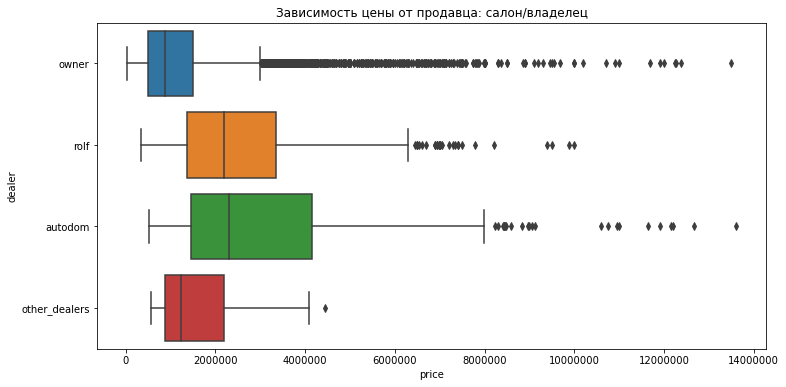

In [67]:
plt.rcParams['figure.figsize']=12,6
plt.ticklabel_format(style='plain', axis='x')
horizontal_boxplots('price', 'dealer', df, 'Зависимость цены от продавца: салон/владелец')

Интересно. Частные лица, владельцы авто(**owner**) продают гораздо дешевле, чем салоны. У больших автосалонов (*РОЛЬФ, АВТОДОМ*) цены могут быть еще выше чем у других салонов, но это объясняет более дорогими авто. Остальные мелкие дилеры занимают промежуточное место.  

### discount - возможен торг или нет

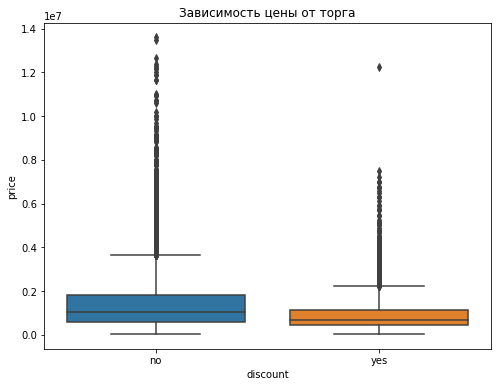

In [68]:
vertical_boxplots('price', 'discount', df, 'Зависимость цены от торга', fsize=[8,6])

B целом цены на авто, где и так предусмотен торг - ниже, чем не те, где нет. Хотя максимальная цена может быть около 8 млн, а максимальная 12 млн.  

### generation - поколение, рестайлинг и пр.   
Каждый из моделей BMW имела несколько поколений (кроме свосем новых). Модель получается свой буквенно-номерной код (E53, F15 и пр.) Это влияет на набор опций, двигатель, экономичность и пр. Но у каждой модели - своя история, поэтому вместо признака запуск модели в производство, создадим признак - поколение **generation**  
Приедставлено несколько модельных рядов.  
5 - серия (все что 5xx и далее, цифры обозначают объем двигателя, добавочная буква - тип топлива)   
По серии и году запуска модели, можно определить поколение   
Поколение будем считать для каждой модели отдельно, и присваивать обозначение BMW

In [69]:
df.model = df.model.apply(lambda x: str(x).strip())
df = df.apply(serie_creator, axis=1);

df.loc[df.model.str.contains('L'), 'serie'] = '7L'
df.loc[df.model.str.contains('L'), 'bodytype'] = 'limousin'

Иногда в описании **7L** считается представительским классом и рассматривается отдельно. Вернем класс кузова **limousine** для этой серии

In [70]:
########## X - serie 
# BMW X1
df.loc[(df.model_year.between(2009,2011))&(df.serie=='X1'), 'generation']  = '1|E84'
df.loc[(df.model_year.between(2012,2015))&(df.serie=='X1'), 'generation'] = '2|E84-Res'
df.loc[(df.model_year.between(2015,2019))&(df.serie=='X1'), 'generation'] = '3|F48'
df.loc[(df.model_year>2019)&(df.serie=='X1'), 'generation'] = '4|F48-Res'

# BMW X2
df.loc[(df.serie=='X2'), 'generation']  = '1|F39'

# BMW X3
df.loc[(df.model_year.between(2003,2009))&(df.serie=='X3'), 'generation']  = '1|E83'
df.loc[(df.model_year.between(2010,2016))&(df.serie=='X3'), 'generation'] = '2|F25'
df.loc[(df.model_year.between(2017,2020))&(df.serie=='X3'), 'generation'] = '3|G01'

# BMW X4
df.loc[(df.model_year.between(2000,2017))&(df.serie=='X4'), 'generation']  = '1|F26'
df.loc[(df.model_year.between(2017,2021))&(df.serie=='X4'), 'generation'] = '2|G02'

# BMW X5
df.loc[(df.model_year.between(1999,2005))&(df.serie=='X5'), 'generation']  = '1|E53'
df.loc[(df.model_year.between(2006,2012))&(df.serie=='X5'), 'generation'] = '2|E70'
df.loc[(df.model_year.between(2013,2017))&(df.serie=='X5'), 'generation'] = '3|F15'
df.loc[(df.model_year>2017)&(df.serie=='X5'), 'generation'] = '4|G05'

# BMW X6
df.loc[(df.model_year.between(2000,2012))&(df.serie=='X6'), 'generation']  = '1|E71'
df.loc[(df.model_year.between(2012,2014))&(df.serie=='X6'), 'generation']  = '1|E71-Res'
df.loc[(df.model_year.between(2014,2019))&(df.serie=='X6'), 'generation'] = '2|F16'
df.loc[(df.model_year.between(2019,2020))&(df.serie=='X6'), 'generation'] = '3|G06'

# BMW X7
df.loc[(df.serie=='X7'), 'generation']  = '1|G07'

######### Z - Serie

# BMW Z1
df.loc[(df.model_year<2000)&(df.serie=='Z1'), 'generation']  = '1|Z1'
df.loc[(df.model_year.between(2000,2003))&(df.serie=='Z1'), 'generation'] = '1|Z1-Res'

# BMW Z3
df.loc[(df.model_year<2000)&(df.serie=='Z3'), 'generation']  = '1|Z3'
df.loc[(df.model_year.between(2000,2003))&(df.serie=='Z3'), 'generation'] = '1|Z3-Res'


# BMW Z4 
df.loc[(df.model_year<2005)&(df.serie=='Z4'), 'generation']  = '1|E85'
df.loc[(df.model_year.between(2005,2009))&(df.serie=='Z4'), 'generation'] = '1|E85-Res'
df.loc[(df.model_year.between(2009,2013))&(df.serie=='Z4'), 'generation'] = '2|E89'
df.loc[(df.model_year.between(2013,2017))&(df.serie=='Z4'), 'generation'] = '3|F89-Res'
df.loc[(df.model_year.between(2018,2020))&(df.serie=='Z4'), 'generation'] = '3|G29'

########## M - Serie

# BMW M1
df.loc[(df.serie=='M1'), 'generation']  = '1|E26'

# BMW M2
df.loc[(df.serie=='M2'), 'generation']  = '1|F22'

# BMW M3
df.loc[(df.model_year<1992)&(df.serie=='M3'), 'generation']  = '1|E30'
df.loc[(df.model_year.between(1992,1999))&(df.serie=='M3'), 'generation'] = '2|E36'
df.loc[(df.model_year.between(1999,2007))&(df.serie=='M3'), 'generation'] = '3|F46'
df.loc[(df.model_year.between(2007,2014))&(df.serie=='M3'), 'generation'] = '4|E60'
df.loc[(df.model_year.between(2014,2018))&(df.serie=='M3'), 'generation'] = '5|F80'
df.loc[(df.model_year.between(2019,2020))&(df.serie=='M3'), 'generation'] = '6|G80'

# BMW M4
df.loc[(df.model_year<2017)&(df.serie=='M4'), 'generation']  = '1|F82'
df.loc[(df.model_year.between(2017,2019))&(df.serie=='M4'), 'generation'] = '1|F82-Res'
df.loc[(df.model_year.between(2020,2021))&(df.serie=='M4'), 'generation'] = '2|G82'

# BMW M5
df.loc[(df.model_year<1988)&(df.serie=='M5'), 'generation']  = '1|E28'
df.loc[(df.model_year.between(1988,1996))&(df.serie=='M5'), 'generation'] = '2|E34'
df.loc[(df.model_year.between(1998,2004))&(df.serie=='M5'), 'generation'] = '3|F39'
df.loc[(df.model_year.between(2004,2011))&(df.serie=='M5'), 'generation'] = '4|E60'
df.loc[(df.model_year.between(2011,2017))&(df.serie=='M5'), 'generation'] = '5|F10'
df.loc[(df.model_year.between(2017,2020))&(df.serie=='M5'), 'generation'] = '6|F90'
df.loc[(df.model_year.between(2020,2021))&(df.serie=='M5'), 'generation'] = '6|F90-Res'

# BMW M6
df.loc[(df.model_year<1992)&(df.serie=='M6'), 'generation']  = '1|E24'
df.loc[(df.model_year.between(1991,2011))&(df.serie=='M6'), 'generation'] = '2|E63'
df.loc[(df.model_year.between(2011,2021))&(df.serie=='M6'), 'generation'] = '3|F06'

# BMW M8
df.loc[(df.serie=='M8'), 'generation']  = '1|F91'

######## i - serie
# BMW i3
df.loc[(df.model_year<2018)&(df.serie=='i3'), 'generation']  = '1|I01'
df.loc[(df.model_year.between(2017,2021))&(df.serie=='i3'), 'generation'] = '1|I01-Res'

# BMW i8
df.loc[(df.model_year<2017)&(df.serie=='i8'), 'generation']  = '1|i8'
df.loc[(df.model_year.between(2017,2021))&(df.serie=='i8'), 'generation'] = '1|i8-Res'



######## 1-8 Serie
# 1 serie
df.loc[(df.model_year<2010)&(df.serie=='1'), 'generation']  = '1|E87'
df.loc[(df.model_year>2010)&(df.serie=='1'), 'generation']  = '2|F20'

# 2 serie
df.loc[(df.model_year<2017)&(df.serie=='2'), 'generation']  = '1|F22'
df.loc[(df.model_year.between(2017,2019))&(df.serie=='2'), 'generation'] = '1|F22-Res'
df.loc[(df.model_year.between(2019,2021))&(df.serie=='2'), 'generation'] = '2|F44'

# 3 serie
df.loc[(df.model_year<1983)&(df.serie=='3'), 'generation']  = '1|E21'
df.loc[(df.model_year.between(1983,1993))&(df.serie=='3'), 'generation'] = '2|E30'
df.loc[(df.model_year.between(1993,1999))&(df.serie=='3'), 'generation'] = '3|F36'
df.loc[(df.model_year.between(1999,2006))&(df.serie=='3'), 'generation'] = '4|E46'
df.loc[(df.model_year.between(2005,2011))&(df.serie=='3'), 'generation'] = '5|E90'
df.loc[(df.model_year.between(2011,2018))&(df.serie=='3'), 'generation'] = '6|F30'
df.loc[(df.model_year>2018)&(df.serie=='3'), 'generation'] = '7|G20'

# 4 serie
df.loc[(df.model_year<2017)&(df.serie=='4'), 'generation']  = '1|F32'
df.loc[(df.model_year.between(2017,2020))&(df.serie=='4'), 'generation'] = '2|F32'
df.loc[(df.model_year.between(2020,2021))&(df.serie=='4'), 'generation'] = '3|G22'

# 5 serie
df.loc[(df.model_year<1981)&(df.serie=='5'), 'generation']  = '1|E12'
df.loc[(df.model_year.between(1981,1988))&(df.serie=='5'), 'generation'] = '2|E28'
df.loc[(df.model_year.between(1988,1996))&(df.serie=='5'), 'generation'] = '3|F34'
df.loc[(df.model_year.between(1996,2003))&(df.serie=='5'), 'generation'] = '4|F39'
df.loc[(df.model_year.between(2003,2009))&(df.serie=='5'), 'generation'] = '5|E60'
df.loc[(df.model_year.between(2009,2017))&(df.serie=='5'), 'generation'] = '6|F10'
df.loc[(df.model_year>2017)&(df.serie=='5'), 'generation'] = '7|G30'

# 6 serie
df.loc[(df.model_year<1989)&(df.serie=='6'), 'generation']  = '1|E24'
df.loc[(df.model_year.between(2003,2007))&(df.serie=='6'), 'generation'] = '2|E63'
df.loc[(df.model_year.between(2007,2011))&(df.serie=='6'), 'generation'] = '2|F63-Res'
df.loc[(df.model_year.between(2011,2015))&(df.serie=='6'), 'generation'] = '3|F06'
df.loc[(df.model_year.between(2015,2018))&(df.serie=='6'), 'generation'] = '3|F06-Res'
df.loc[(df.model_year.between(2017,2020))&(df.serie=='6'), 'generation'] = '4|G32'
df.loc[(df.model_year==2020)&(df.serie=='6'), 'generation'] = '4|G32-Res'

# 7 serie
df.loc[(df.model_year<1987)&(df.serie=='7'), 'generation']  = '1|E23'
df.loc[(df.model_year.between(1987,1993))&(df.serie=='7'), 'generation'] = '2|E32'
df.loc[(df.model_year.between(1993,2000))&(df.serie=='7'), 'generation'] = '3|F38'
df.loc[(df.model_year.between(2000,2007))&(df.serie=='7'), 'generation'] = '4|E65'
df.loc[(df.model_year.between(2007,2014))&(df.serie=='7'), 'generation'] = '5|F01'
df.loc[(df.model_year.between(2014,2020))&(df.serie=='7'), 'generation'] = '6|G11'

# 7L serie
df.loc[(df.model_year<1987)&(df.serie=='7L'), 'generation']  = '1|E23'
df.loc[(df.model_year.between(1987,1993))&(df.serie=='7L'), 'generation'] = '2|E32'
df.loc[(df.model_year.between(1993,2000))&(df.serie=='7L'), 'generation'] = '3|F38'
df.loc[(df.model_year.between(2000,2007))&(df.serie=='7L'), 'generation'] = '4|E66'
df.loc[(df.model_year.between(2007,2014))&(df.serie=='7L'), 'generation'] = '5|F02'
df.loc[(df.model_year.between(2014,2020))&(df.serie=='7L'), 'generation'] = '6|G12'



# 8 serie
df.loc[(df.serie=='8'), 'generation']  = '2|G14'

In [71]:
# год модели больше не нужен
df.drop(columns=['model_year'], inplace=True)

Посмотрим на различия в моделях. Построим теже боксплоты, которые строили для **model_year** и построим для самой популярной **X5**

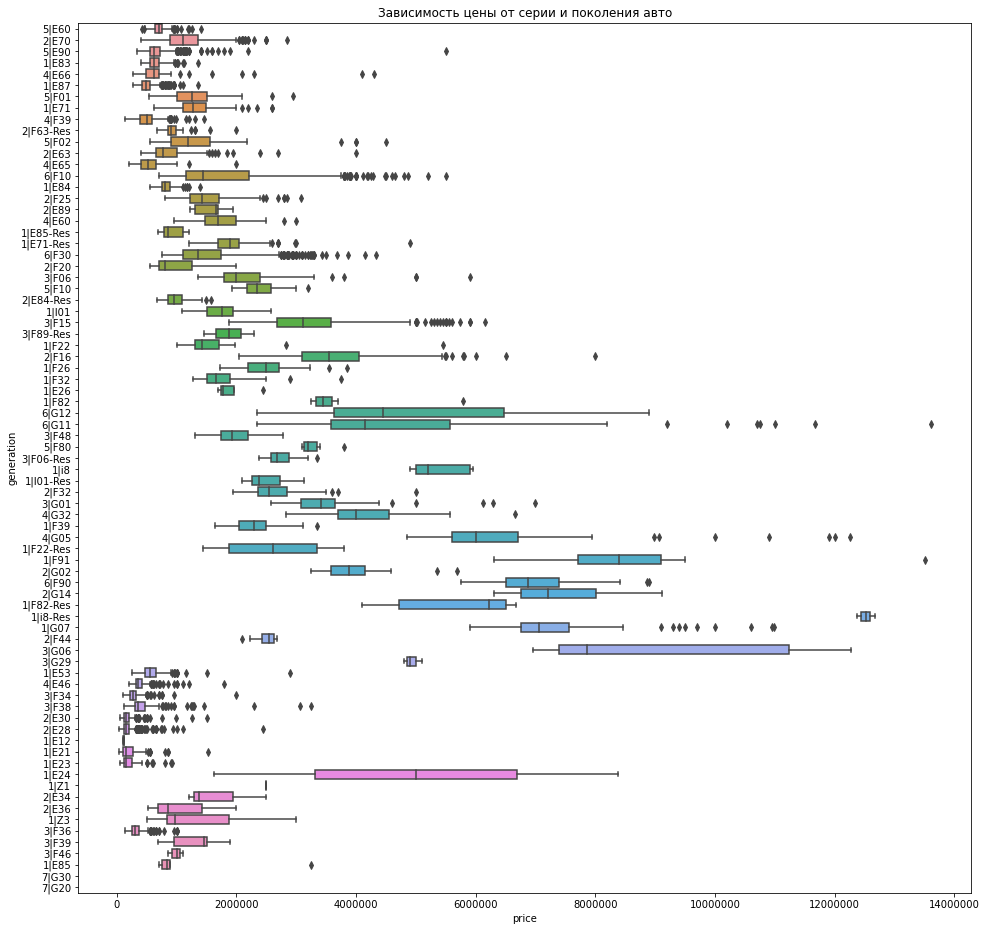

In [72]:
plt.rcParams['figure.figsize']=16,16
plt.ticklabel_format(style='plain', axis='x')
horizontal_boxplots('price', 'generation', df, 'Зависимость цены от серии и поколения авто')

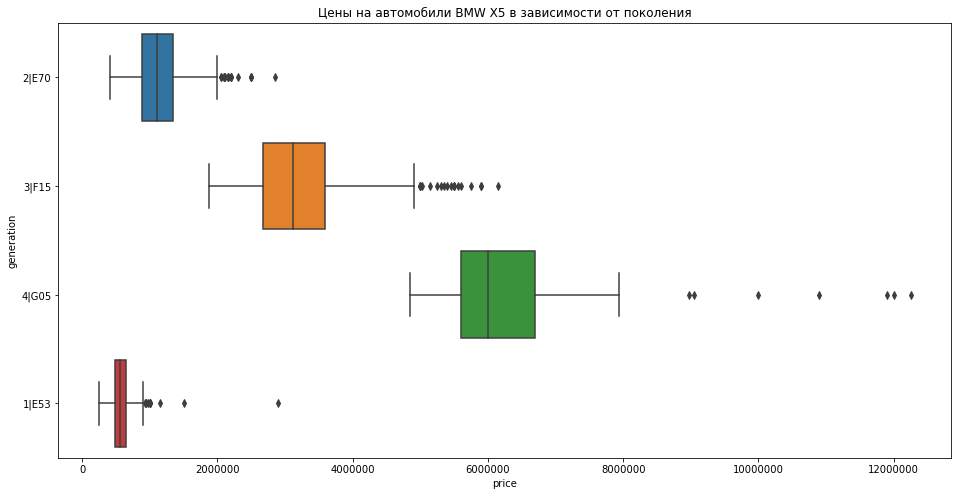

In [73]:
plt.rcParams['figure.figsize']=16,8
plt.ticklabel_format(style='plain', axis='x')
horizontal_boxplots('price', 'generation', df[df.model=='X5'], 'Цены на автомобили BMW X5 в зависимости от поколения')

Для BMW-X5 получилась наглядная картина. Если судить по усам, то примерно где кончается верхний квантиль по цене 2го поколения (75%) начинается первый квантиль 3го поколения. Если не считать первое поколение и выбросы.  

### tax - транспортный налог

Рассчитаем транпотный налог(базовую ставку) и добавим в столбец **tax**

In [74]:
df = df.apply(auto_tax, axis=1)

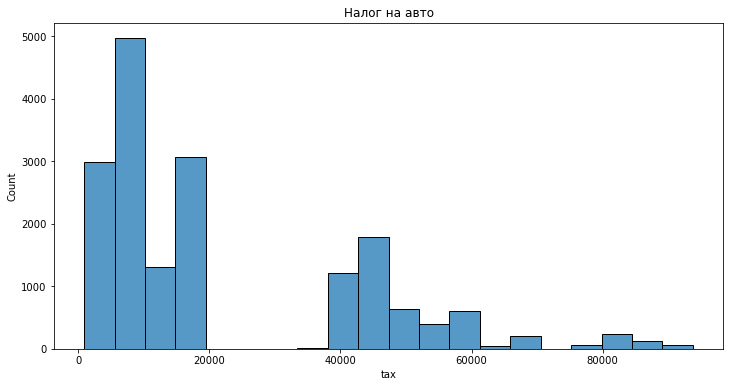

In [75]:
plt.rcParams['figure.figsize']=12,6
plt.ticklabel_format(style='plain', axis='x')
sns.histplot(x='tax', data=df, kde=False, bins=20)
plt.title('Налог на авто')
plt.show()

Вот так выглядит налог на дорогие BMW и не очень. Из-за большого скачка для двигателей свыше 250 л.с. Поэтому есть смысла купить авто с мощностью чуть менее 250 л.с.   

Из итогового датафрейма (см. ниже) выделим списки категориальных, числовых и бинарных признаков:

### age-type - категория возраста.  
Есть закономерность, что как только новый автомобиль пересекает выезд из автосалона сразу теряет 10% в цене. Если посмотреть на график в EDA для года запуска модели или возраста, то можно выделить такие категории: 
* Новое авто 0-1 года
* б/у новое 2-5 лет, как правило уже отражается на износе, страховке и пр. 
* б/у 6-10, авто часто требует вложений
* более 10 лет

In [76]:
# категории авто
df.loc[df.car_age.between(0,1), 'age_type'] = 'new_car'
df.loc[df.car_age.between(2,5), 'age_type'] = 'used_car'
df.loc[df.car_age.between(6,10), 'age_type'] = 'midage_car'
df.loc[df.car_age.between(10,18), 'age_type'] = 'old_car'
df.loc[df.car_age>18, 'age_type'] = 'rare_car'

Нечасто, но бывает, что старые авто восстанавливают, такие авто отражены с более малым пробегом и в описании содержатся отличия от базовых моделей и пр. Такие авто вынесем еще в одну категорию - *rebuild_car* 

In [77]:
# медианный пробег для каждого года выпуска и тип восстановленный авто
med_miles = df.groupby('car_age')['miles'].median().to_dict()
df.loc[(df.miles<20000)&(df.car_age>11)&(df.bodytype!='roadster'), 'age_type'] = 'rebuild_car'

In [78]:
def miles_add(row):
    row['miles'] = row['miles'] + med_miles[row['car_age']]
    return row

df.loc[(df.miles<20000)&(df.car_age>11)&(df.bodytype!='roadster')] = df.loc[
    (df.miles<20000)&(df.car_age>11)&(df.bodytype!='roadster')].apply(
    miles_add, axis=1)

### sport-car - спортивный автомобиль  
BMW выпускает линейку спорткаров это родстеры Z-серии, M-серии (тюнингованные серийные BMW). А также тюнингованные в других ателье или собранные под другие задачи.

In [79]:
df.loc[df.serie.str.contains('Z'), 'sportcar'] = 'yes'
df.loc[df.serie.str.contains('M'), 'sportcar'] = 'yes'
df.loc[df.serie.str.contains('i8'), 'sportcar'] = 'yes'

Посмотрим, какая мощность у серийных спорткаров. 25% квантиль около 400 л.с. Можно предположить, что владельцы серийных BMW, которые тюнингуют свои авто, должны быть больше чем 400 л.с.

In [80]:
df.loc[~df.sportcar.isna(), 'power'].describe()

count   275.00
mean    437.36
std     135.03
min     115.00
25%     340.00
50%     431.00
75%     560.00
max     625.00
Name: power, dtype: float64

In [81]:
sport_bodytypes = ['sedan', 'cabriolet', 'coupe', 'hatchbek_3d', 'roadster', 'sedan_2d']
df.loc[df.descr.str.contains('спорт')&(df.bodytype.isin(sport_bodytypes))&(
    df.dealer=='owner')&(df.power>400), 'sportcar'] = 'yes'

In [82]:
df.loc[df.sportcar.isna(), 'sportcar'] = 'no'

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17737 entries, 0 to 3836
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bodytype      17737 non-null  object 
 1   color         17737 non-null  object 
 2   descr         17737 non-null  object 
 3   drive         17737 non-null  object 
 4   engine_displ  17737 non-null  float64
 5   fuel          17737 non-null  object 
 6   id            17737 non-null  object 
 7   miles         17737 non-null  float64
 8   model         17737 non-null  object 
 9   options       17737 non-null  object 
 10  owners        17737 non-null  object 
 11  power         17737 non-null  int64  
 12  price         13900 non-null  float64
 13  car_age       17737 non-null  int64  
 14  pts           17737 non-null  object 
 15  train         17737 non-null  int64  
 16  transm        17737 non-null  object 
 17  dealer        17737 non-null  object 
 18  discount      17737 non-nul

In [84]:
# признак descr - больше не нужен
df.drop(columns = ['descr'], inplace=True)

### options - отдельные опции

По отдельным опциям при подоготовке данных для обучение будет сделано кодирование признаков. 

In [85]:
# разделение столбцов по категориям
bin_cols = ['pts', 'discount', 'sportcar']
cat_cols = ['bodytype', 'color', 'drive', 'fuel', 'model', 'owners', 'transm', 
            'dealer', 'serie', 'generation','age_type']
num_cols = ['engine_displ', 'miles', 'power', 'car_age', 'tax']

## Корреляционный анализ числовых переменных

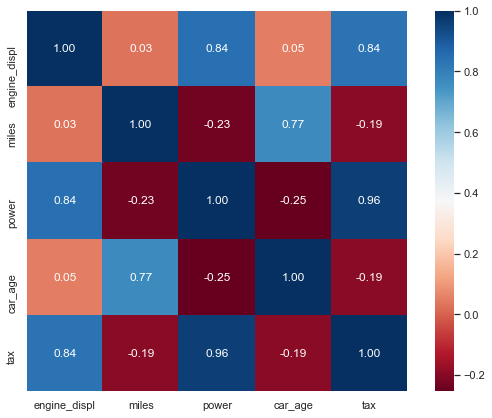

In [86]:
# теперь посмотрим на корреляцию числовых признаков между собой
sns.set (font_scale=1)
plt.subplots (figsize=(10,7))
sns.heatmap(df[num_cols].corr(), square=True, annot=True, fmt=".2f", cmap="RdBu");

Высокий коэффициент корреляции между признаками возраст авто (**car_age**) и пробег (**miles**), объем двигателя, мощность и налог (**engine_displ, **power**, **tax**)  

In [87]:
gen_taxes = df.query('train==1').groupby('generation')['tax', 'price'].mean()
gen_taxes['tax_pr'] = gen_taxes['tax']*100 / gen_taxes['price']
tax_pr = gen_taxes[['tax_pr']].to_dict();

In [88]:
# заменяем налог на относительный налог
df['tax'] = df['generation'].map(tax_pr['tax_pr'])

In [89]:
df.head(3)

,bodytype,color,drive,engine_displ,fuel,id,miles,model,options,owners,...,pts,train,transm,dealer,discount,serie,generation,tax,age_type,sportcar
0,sedan,white,rear,2.00,diesel,https://auto.ru/cars/used/sale/bmw/5er/1095912...,220000.00,520,"['Электростеклоподъёмники задние', 'Электросте...",3,...,original,1,mech,owner,no,5,5|E60,2.53,old_car,no
2,suv_5d,black,full,4.80,petrol,https://auto.ru/cars/used/sale/bmw/x5/11010944...,203000.00,X5,"['Круиз-контроль', 'Электрорегулировка руля', ...",3,...,duplicate,1,auto,owner,no,X5,2|E70,3.60,old_car,no
3,sedan,black,rear,2.00,petrol,https://auto.ru/cars/used/sale/bmw/3er/1098844...,118000.00,320,[],3,...,original,1,auto,owner,yes,3,5|E90,1.71,old_car,no


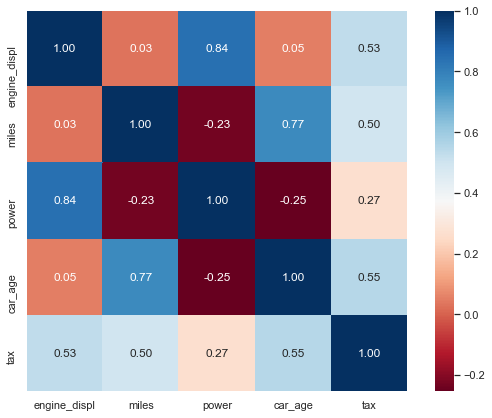

In [90]:
# теперь посмотрим на корреляцию числовых признаков между собой после преобразований
sns.set (font_scale=1)
plt.subplots (figsize=(10,7))
sns.heatmap(df[num_cols].corr(), square=True, annot=True, fmt=".2f", cmap="RdBu");

Признак объем двигателя остается сильно скоррелированным с мощностью и налогом. Но при этом не не сет полезной информации, т.к. больше указывает на модель авто, чем на цену.  
Удалим этот признак.

In [91]:
df.drop(columns = ['engine_displ'], inplace=True)

*Примечание*  
Подготовка списка опция была сделана отдельно и сохранена в файл. Загружаем файл, производим кодирование признаков и удаляем столбец. 

In [92]:
dict_option=pd.read_csv('options_extract.csv')
for i in dict_option.option.to_list():
    df[i] = 0
for j in dict_option.option.to_list():
    df.loc[df.options.str.contains(j, regex=False), j] = 1

In [93]:
df.drop(columns = ['options'], inplace=True)

### miles_ratio

Для каждого поколения в серии добавим признак, как средний пробег автомобиля относительно среднего пробега всех авто этого поколения. Это позволит находить авто, которые меньше использовались. 100 тыс пробега для 3х летнего автомобиля и для 10-летнего это совсем разные показатели. 

In [94]:
med_miles = df.groupby('generation')['miles'].mean().to_dict()

def miles_serie_ratio(row):
    serie_med = float(med_miles[row['generation']])
    row['miles_ratio'] = row['miles'] / serie_med
    return row

df = df.apply(miles_serie_ratio, axis=1)

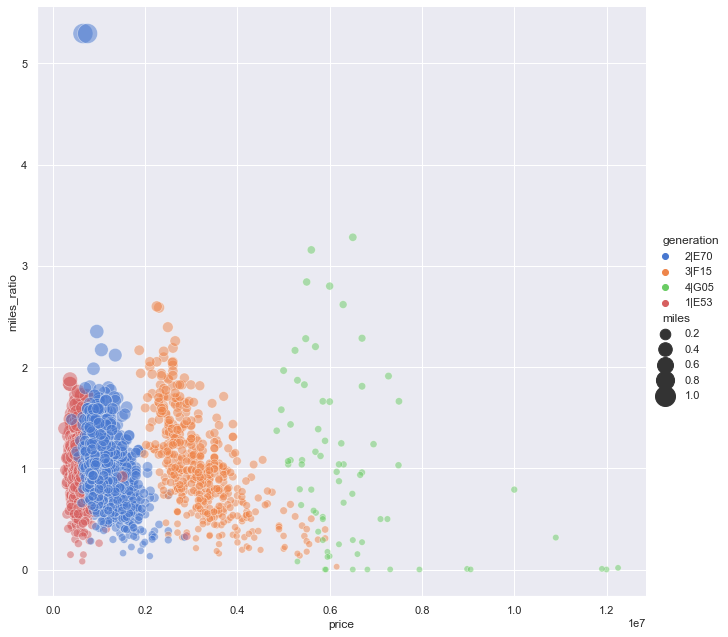

In [95]:
mr = sns.relplot(x="price", y="miles_ratio", hue='generation', size="miles",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=9, data=df[df.model=='X5']);

Относительное значение пробега для поколения лучше показывает его влияние, чем сам пробег.  
Например в ценовой диапазон более 5 млн. попадают только новые G05 и F15 3го поколения с miles_ratio < 0.7. При этом сам пробег может насчитывать десятки тыс. км. 

In [96]:
pd.set_option('display.max_columns', None) 

In [97]:
# Копия датафрейма для catboost 
df = df.reset_index(drop=True)
df2 = df.copy()

In [99]:
# разделение столбцов по категориям
bin_cols = ['pts', 'discount', 'sportcar']
cat_cols = ['bodytype', 'color', 'drive', 'fuel', 'model', 'owners', 'transm', 
            'dealer', 'serie', 'generation','age_type']
num_cols = ['engine_displ', 'miles', 'power', 'car_age', 'tax', 'miles_ratio']

## Подготовка моделей для ML  

### BAGGING FORREST

In [100]:
def mape(y_true, y_pred): # необходимая метрика оценки качества
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [101]:
# фиксируем глобальные переменные

RANDOM_SEED=42
#VERSION = 12
VAL_SIZE = 0.2

In [102]:
sample_submission = pd.read_csv('sample_submission.csv')

Подготовим финальную предобработку. Разобьем столбцы при помощи get_dummies (one-hot encoding). Масштабируем (разница курса евро апрель-ноябрь) и логарифмируем ее. 

In [103]:
df['price'] = df['price'] * 0.9375
df['price'] = np.log(df['price'])


X = np.array(df['miles']).reshape(-1,1)
df['miles'] = power_transform(X)

X = np.array(df['power']).reshape(-1,1)
df['power'] = power_transform(X)

X = np.array(df['car_age']).reshape(-1,1)
df['car_age'] = power_transform(X)

In [104]:
cols_dum = ['bodytype', 'color', 'fuel', 'model', 'owners', 'serie', 'pts', 'dealer', 'generation', 
            'age_type', 'discount', 'sportcar', 'transm', 'drive']

df = pd.get_dummies(df, columns = cols_dum, dummy_na=False)

df = df.fillna(0)

In [142]:
# Разбиваем наш датафрейм на признаки, целевую переменную и тестовую выборки 
test_data = df[df.train==0].drop(['id', 'price', 'train'], axis=1)
X = df[df.train==1].drop(['id', 'price', 'train'], axis=1)
y = df[df.train==1]['price'].values

In [143]:
# Разбиваем на тестовую и тренировочную выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

### RANDOM FORREST REGRESSOR / RandomizedSearchCV

In [107]:
####### 
# закомментирован так как выполняется очень долго

# позволяет закрепить random_state во всей ячейке исполнения
#np.random.seed(42)

#n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1500, num = 50)]
#max_features = ['auto', 'sqrt', 'log2']
#max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)
#min_samples_split = [2, 5, 10]
#min_samples_leaf = [1, 2, 4]
#bootstrap = [True, False]
#random_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap}

#rf = RandomForestRegressor()
#rf_random = RandomizedSearchCV(estimator = rf, 
#                               param_distributions = random_grid, 
#                               n_iter = 100, 
#                               cv = 3, 
#                               verbose=0, 
#                               random_state=RANDOM_SEED, 
#                               n_jobs = -1)
#rf_random.fit(X_train, y_train)

In [108]:
#rf_random.best_params_

In [109]:
VERSION = 7
models = [RandomForestRegressor(n_estimators =842,random_state = RANDOM_SEED, n_jobs = -1, verbose = 0, 
        min_samples_split=10, min_samples_leaf=1, max_features='auto', max_depth=70),
         BaggingRegressor(ExtraTreesRegressor(random_state=RANDOM_SEED), random_state=RANDOM_SEED)]

def stacking_model_predict(models, X, y, test_data, sample_submission):
    for model_ in tqdm(models):
        model_.fit(X, y)
        pred_subm = model_.predict(test_data)
        sample_submission[str(model_)[:6]] = pred_subm
        sample_submission[str(model_)[:6]] = sample_submission[str(model_)[:6]].apply(lambda x: np.exp(x) )
        sample_submission[str(model_)[:6]] = sample_submission[str(model_)[:6]].apply(lambda x: round(x/1000)*1000)
    sample_submission['price'] = sample_submission.iloc[:,2:].mean(axis=1)
    sample_submission[['id', 'price']].to_csv(f'submission_v{VERSION}.csv', index=False)
    sample_submission.head(10)

stacking_model_predict(models, X, y, test_data, sample_submission)

#### KAGGLE SCORE - 14.55   
Такая оценка получилась от использования RFR с Bagging Regressor  
*submission_v7*

### XGBOOST 

In [144]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [111]:
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(4, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
}

In [112]:
xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}

In [113]:
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: mape(y, pred)

In [114]:
obj = HPOpt(X_train, X_test, y_train, y_test)

In [115]:
# Подбор праметров с помощью HyperOpt
xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

100%|██████████| 100/100 [02:33<00:00,  1.53s/trial, best loss: 0.009876542517127987]


In [140]:
xgb_opt

({'colsample_bytree': 2,
  'learning_rate': 1,
  'max_depth': 5,
  'min_child_weight': 3,
  'subsample': 0.9714447633471278},
 <hyperopt.base.Trials at 0x192753d74c0>)

In [145]:
model_X = xgb.XGBRegressor(
    colsample_bytree= 1,
    learning_rate= 1,
    max_depth= 6,
    min_child_weight= 2,
    subsample= 0.917,
    eval_metric='mae')

model_X.fit(X_train, y_train)
y_pred = model_X.predict(X_test)

In [146]:
y_pred = np.exp(y_pred)

In [147]:
mape(np.exp(y_test), y_pred)

0.17793137316928118

**MAPE** стала хуже в 2 раза по сравнению с RandomForrestRegressor

In [148]:
def model_xgb(y_train, X_train, X_test, y_test):
    model = xgb.XGBRegressor(
    colsample_bytree= 1,
  learning_rate= 1,
  max_depth= 8,
  min_child_weight= 3,
  subsample= 0.91112339,
  eval_metric='mae')
    model.fit(X_train, y_train)
    
    return(model)

### Blending

In [149]:
N_FOLDS = 5
submissions = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.index)


from sklearn.model_selection import RepeatedKFold
score_ls = []
splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED).split(X, y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
    # use the indexes to extract the folds in the train and validation data
    X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]
    # model for this fold
    model = model_xgb(y_train, X_train, X_test, y_test)
    # score model on test
    test_predict = model.predict(X_test)
    #test_predict = np.exp(test_predict)
    test_score = mape(y_test, test_predict)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(y_test, test_predict):0.3f}")
    # submissions
    submissions[f'sub_{idx+1}'] = model.predict(test_data)
    #model.save_model(f'catboost_fold_{idx+1}.model')
    
print(f'Mean Score: {np.mean(score_ls):0.3f}')
print(f'Std Score: {np.std(score_ls):0.4f}')
print(f'Max Score: {np.max(score_ls):0.3f}')
print(f'Min Score: {np.min(score_ls):0.3f}')

1 Fold Test MAPE: 0.014
2 Fold Test MAPE: 0.015
3 Fold Test MAPE: 0.014
4 Fold Test MAPE: 0.014
5 Fold Test MAPE: 0.014

Mean Score: 0.014
Std Score: 0.0002
Max Score: 0.015
Min Score: 0.014


In [150]:
y_pred = submissions.mean(axis=1)
y_pred = np.exp(y_pred)

In [151]:
submission = y_pred.apply(price_round).reset_index()
submission.columns = ['id', 'price']

In [152]:
VERSION = 8
submission[['id', 'price']].to_csv(f'submission_v{VERSION}.csv', index=False)

#### KAGGLE SCORE - 15.64
Такая оценка получилась от использования XGR + Hyperopt  
*submission_v8*   
на *KAGGLE* **MAPE** стало хуже на 1 процент. Слишком большая разница между оценками *KAGGLE* объясняется тем, что мы предсказываем апрельские цены, ценами которые спарсили недавно (конец октября). Лучшие результаты основаны на более старых датасетах. 

## Stacking (RFR + XGBR) Regressor

Попробуем собрать 2 модели вместе. Random Forrest Regressor + XGBoost Regressor

In [153]:
model_X = xgb.XGBRegressor(
    colsample_bytree= 1,
  learning_rate= 1,
  max_depth= 8,
  min_child_weight= 3,
  subsample= 0.91112339,
  eval_metric='mae')

model_R = RandomForestRegressor(n_estimators =842,random_state = RANDOM_SEED, n_jobs = -1, verbose = 0, 
        min_samples_split=10, min_samples_leaf=1, max_features='auto', max_depth=70)

ridge = RidgeCV()

svr_rbf = SVR(kernel='rbf')

In [154]:
stregr = StackingRegressor(regressors=[model_X, model_R], 
                           meta_regressor=svr_rbf)

In [155]:
stregr.fit(X_train, y_train)
submission_stacked = stregr.predict(test_data)

In [156]:
submission_stacked = pd.Series(submission_stacked)
submission_stacked = submission_stacked.reset_index()
submission_stacked.columns = ['id', 'price']
submission_stacked['price'] = submission_stacked['price'].apply(lambda x: np.exp(x)-1)
submission_stacked['price'] = submission_stacked['price'].apply(lambda x: price_round(x))

In [157]:
VERSION = 9
submission_stacked[['id', 'price']].to_csv(f'submission_v{VERSION}.csv', index=False)

#### KAGGLE SCORE - 20.74    
Стекинг из двух алгоритмов RFR и XGR показал совсем плохой результат на *KAGGLE*. Возможно модель переобучилась, а может настолько отличаются предсказанные цены. 

## CATBOOST

In [158]:
df2['price'] = df2['price'] * 0.9375
df2['price'] = np.log(df2['price'])


X = np.array(df2['miles']).reshape(-1,1)
df2['miles'] = power_transform(X)

X = np.array(df2['power']).reshape(-1,1)
df2['power'] = power_transform(X)

X = np.array(df2['car_age']).reshape(-1,1)
df2['car_age'] = power_transform(X)


#cols_dum = ['bodytype', 'color', 'fuel', 'model', 'owners', 'serie', 'pts', 'dealer', 'generation', 
#            'age_type', 'discount', 'sportcar', 'transm', 'drive']

num_cols = ['miles', 'power', 'car_age', 'tax', 'miles_ratio']


# Разбиваем наш датафрейм на признаки, целевую переменную и тестовую выборки 
test_data = df2[df2.train==0].drop(['id', 'price', 'train'], axis=1)
X = df2[df2.train==1].drop(['id', 'price', 'train'], axis=1)
y = df2[df2.train==1]['price'].values
X = X.fillna(0)

In [159]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42)

In [160]:
# Убираем из списка столбцов, числовые переменные, оставляем только категорийные
cat_features = set(X.columns).difference(set(num_cols))

In [161]:
from catboost import Pool
import sklearn.metrics
def objective(trial):
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=47)
    train_pool = Pool(train_x, train_y, cat_features=cat_features)
    test_pool = Pool(test_x, test_y, cat_features=cat_features)

    params = {
        'iterations' : trial.suggest_int('iterations', 50, 980),                         
        'depth' : trial.suggest_int('depth', 4, 10),                                       
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),               
        'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), 
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait' :trial.suggest_int('od_wait', 10, 50)
    }

    model = CatBoostRegressor(**params)
    model.fit(train_pool)
    preds = model.predict(test_pool)
    pred_labels = np.rint(preds)
    accuracy = mape(test_y, pred_labels)
    return 1.0 - accuracy

Проведем подбор параметров с помощью **optuna**

In [162]:
#import optuna
#if __name__ == '__main__':
#    study = optuna.create_study()
#    study.optimize(objective, n_trials=5)
#    print(study.best_trial)

In [163]:
#study.best_params

In [164]:
#optuna.visualization.plot_slice(study)

In [165]:
X_sub=df2[df2.train==0].drop(['price','id', 'train'], axis=1)

In [166]:
def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(iterations=1000,
                          learning_rate=0.2,
                          depth=8,
                          random_state=47,
                          random_strength=32,
                          bagging_temperature=0.3,
                          eval_metric='MAPE',
                          od_type='IncToDec',
                          od_wait=18,
                          od_pval=0.002,
                          l2_leaf_reg=1,
                          subsample=0.75)
    
    model.fit(X_train, y_train,
              cat_features=cat_features,
              eval_set=(X_test, y_test),
              verbose=False,
              use_best_model=True,
              plot=False)

    return(model)


In [167]:
# кросс-валидацию по фолдам для борьбы с переобучением
#'''
from sklearn.model_selection import RepeatedKFold

submissions = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.index) # куда пишем предикты по каждой модели
score_ls = []
N_FOLDS = 3
splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=47).split(X, y))
#splits = list(RepeatedKFold(n_splits=N_FOLDS, n_repeats=2, random_state=RANDOM_SEED).split(X, y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
    # use the indexes to extract the folds in the train and validation data
    X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]
    # model for this fold
    model = cat_model(y_train, X_train, X_test, y_test,)
    # score model on test
    test_predict = model.predict(X_test)
    test_score = mape(y_test, test_predict)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(y_test, test_predict):0.3f}")
    # submissions
    submissions[f'sub_{idx+1}'] = model.predict(X_sub)
    model.save_model(f'catboost_fold_{idx+1}.model')
    
print(f'Mean Score: {np.mean(score_ls):0.3f}')
print(f'Std Score: {np.std(score_ls):0.4f}')
print(f'Max Score: {np.max(score_ls):0.3f}')
print(f'Min Score: {np.min(score_ls):0.3f}')
#'''

1 Fold Test MAPE: 0.004
2 Fold Test MAPE: 0.004
3 Fold Test MAPE: 0.004

Mean Score: 0.004
Std Score: 0.0000
Max Score: 0.004
Min Score: 0.004


In [168]:
submissions.loc[:,'blend'] = np.mean(submissions, axis=1)
sample_submission['price'] = np.exp(submissions['blend'].values);
sample_submission['price'] = sample_submission['price'].apply(price_round);
sample_submission.to_csv(f'submission_blend_v1.csv', index=False);
sample_submission.head(10);

## Выводы

В результате данного проекта удалось проверить несколько алгоритмов (CatBoost, XGBoost и др.). Использованы инструменты для приска гиперпараметров (GridSearchCV, HyperOpt, Optune), а также блендинг и стекинг. Но к сожалению не удалось достичь приемлемых результатов. Лучшее значение MAPE на *KAGGLE* примерно 13.5 (CatBoost).Лучшие результаты в таблице лидеров были достигнуты несколько месяцев назад или на старых датасетах, потому что мы пытаемся предсказать цены в апреле, по ценам конца октября, в то время было и изменение курса евро и пандемия и падение продаж авто в целом. На некоторые модели спрос и цены прогнозируемы, но с другими ошибка MAPE могла превышать 100%.  


### P.S.
### Что можно улучшить?  

#### Исследование результатов моделирования

Рассмотрим влияние признаков на целевую метрику **MAPE** на примере модели **XGBoost Regressor**

In [204]:
X = df[df.train==1].drop(['id', 'price', 'train'], axis=1)
y = df[df.train==1]['price'].values

# Разбиваем на тестовую и тренировочную выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)
dm = df2.loc[X_test.index].iloc[:,:21]

In [205]:
model_X.fit(X_train, y_train)
y_pred = model_X.predict(X_test)

In [206]:
dm['pred'] = y_pred

In [209]:
dm['price'] = (dm['price']/0.9375).apply(lambda x: np.exp(x))
dm['pred'] = dm['pred'].apply(lambda x: np.exp(x))

In [210]:
dm['mape_'] = np.abs(dm['price'] - dm['pred'])
dm['mape_'] = dm['mape_'] / dm['price']
dm['mape_'] = dm['mape_'] * 100

In [211]:
dm.mape_.mean()

19.18611716889308

In [212]:
dm.head(2)

,bodytype,color,drive,fuel,id,miles,model,owners,power,price,car_age,pts,train,transm,dealer,discount,serie,generation,tax,age_type,sportcar,pred,mape_
1957,suv_5d,black,full,diesel,https://auto.ru/cars/used/sale/bmw/x6/11008458...,-0.34,X6,3,0.35,1715625.00,-0.23,original,1,auto,owner,yes,X6,1|E71,3.73,midage_car,no,1272784.87,25.81
3509,suv_5d,white,full,diesel,https://auto.ru/cars/used/sale/bmw/x6/11010871...,-0.79,X6,2,0.35,2062500.00,-0.41,original,1,auto,owner,no,X6,1|E71-Res,2.48,midage_car,no,2070381.42,0.38


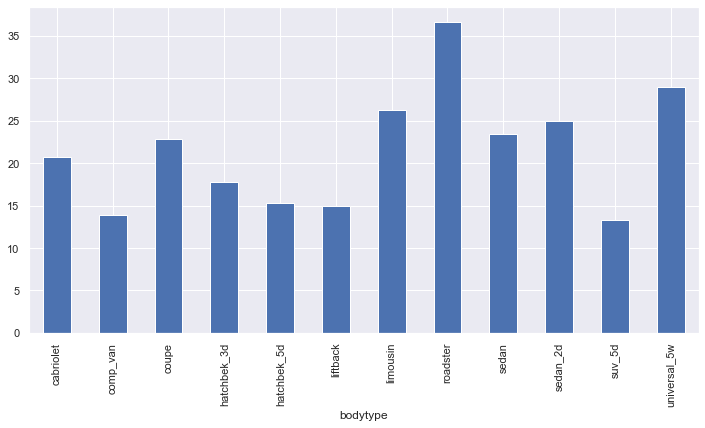

In [213]:
plt.rcParams['figure.figsize']=12,6
data = dm.groupby('bodytype')['mape_'].mean().plot.bar();

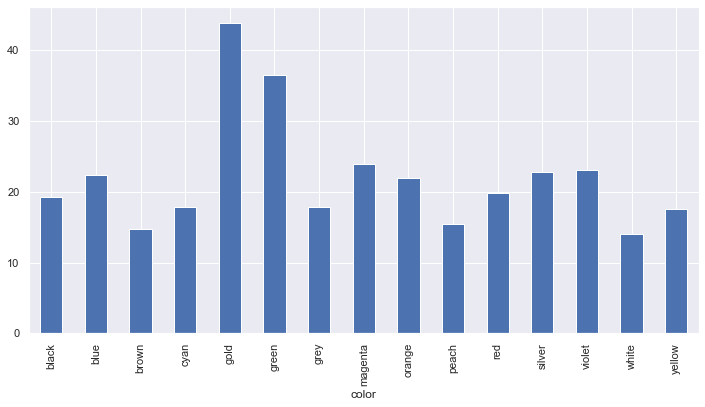

In [214]:
dm.groupby('color')['mape_'].mean().plot.bar();

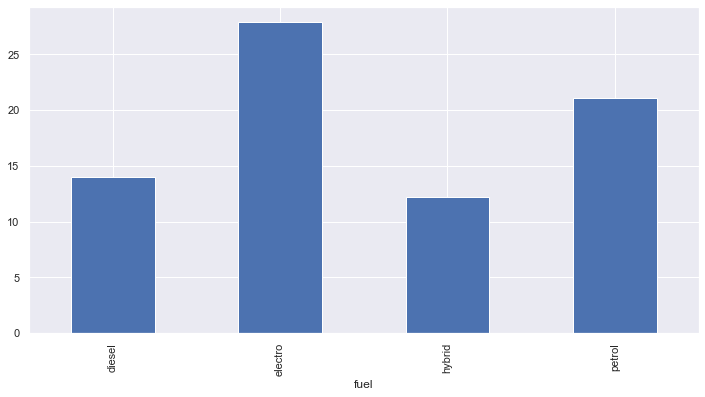

In [215]:
dm.groupby('fuel')['mape_'].mean().plot.bar();

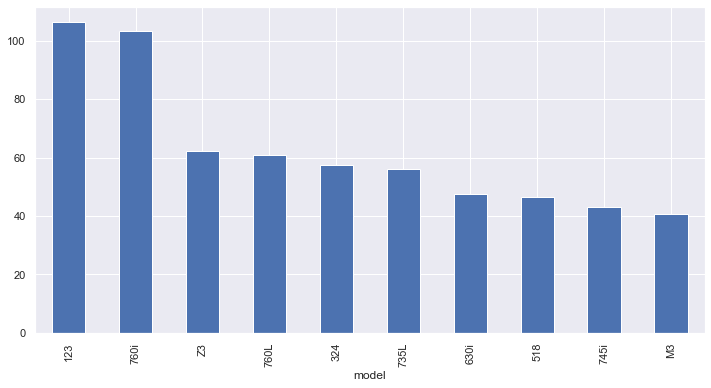

In [216]:
dm.groupby('model')['mape_'].mean().nlargest(10).plot.bar();

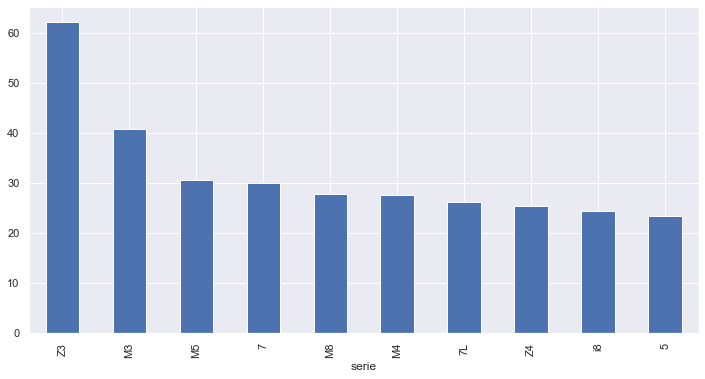

In [217]:
dm.groupby('serie')['mape_'].mean().nlargest(10).plot.bar();

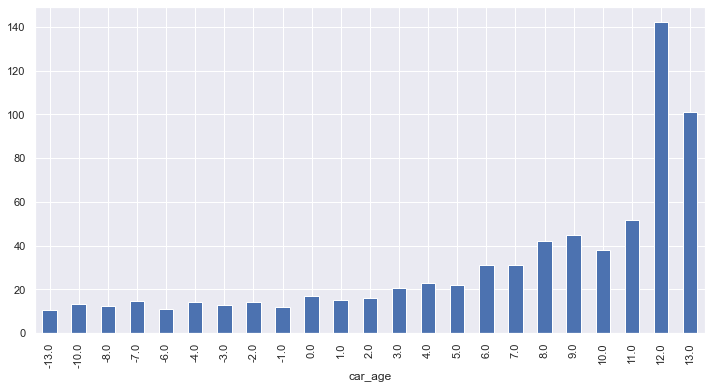

In [218]:
dm.groupby(dm.car_age//0.2)['mape_'].mean().plot.bar();

Модель много ошибается в спортивных автомобилях и моделях представительского класса (Z, M, 7 серии) и соответвующие типу кузовов (родстер, лимузин). Редкие цвета - золотой, фиолетовый, зеленый и др - в них тоже модель ошибается. И самое важное - возраст авто. Чем старше авто - тем больше ошибка.  
Можно выделить отдельные модели BMW и вынести их в отдельные алгоритмы: 
* старые авто
* сгруппировать редкие цвета
* отдельно прогнозировать спортивные, бизнес-авто и электрокары.  


#### P.P.S. CAR PREDICTION V2  
На *KAGGLE* стартовало новое обновленное соревнование, где кроме *BMW* добавлены другие бренды авто и новые признаки. Стоит улучшить модель и попробовать силы в этом соревновании